# **1. Librerías**
 Librerias para manejo de datos y modelado

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import f1_score, recall_score, accuracy_score, classification_report, roc_auc_score, average_precision_score, precision_recall_fscore_support,confusion_matrix
from IPython.display import display

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

import time

from google.colab import files
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE


from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, cross_validate

from sklearn.linear_model import LogisticRegression

import xgboost as xgb

from sklearn.dummy import DummyClassifier

from joblib import dump, load
import os, sys, platform, json, importlib, datetime
from pathlib import Path


In [ ]:

uploaded = files.upload()

# 1) Cargar el archivo separando por cualquier cantidad de espacios
df = pd.read_csv("train_FD001.txt", sep=r"\s+", header=None, engine="python")

# 2) A veces hay una última columna vacía por espacios finales; la eliminamos si está totalmente vacía
df = df.dropna(axis=1, how='all')

# 3) Ver cuántas columnas tiene realmente el dataset
n_cols = df.shape[1]

# En CMAPSS estándar: 31 columnas = 2 (unidad, ciclo) + 3 (ajustes operativos) + 26 sensores
if n_cols == 31:
    nombres_columnas = (
        ['unidad', 'ciclo',
         'ajuste_op_1', 'ajuste_op_2', 'ajuste_op_3'] +
        [f'sensor_{i}' for i in range(1, 27)]  # sensores 1..26
    )
else:
    # Si por alguna razón hay un número distinto de sensores
    if n_cols > 5:
        n_sensores = n_cols - 5
        nombres_columnas = (
            ['unidad', 'ciclo',
             'ajuste_op_1', 'ajuste_op_2', 'ajuste_op_3'] +
            [f'sensor_{i}' for i in range(1, n_sensores + 1)]
        )
    else:
        # Caso muy raro: si no existen sensores, usar nombres genéricos
        nombres_columnas = [f'columna_{i}' for i in range(n_cols)]

# 4) Asignar nombres a las columnas
df.columns = nombres_columnas

# 5) Confirmar tamaño y primeras filas
print("Número de columnas detectadas:", n_cols)
print("Dimensiones del dataset:", df.shape)
df.head()

TypeError: 'NoneType' object is not subscriptable

La idea es predecir si el motor necesita mantenimiento antes de fallar. Para eso, se construye una etiqueta binaria basada en la Remaining Useful Life (RUL):

In [ ]:
# 1) Calcular el ciclo máximo (ciclo de falla) de cada motor
ciclo_maximo = df.groupby('unidad')['ciclo'].max().reset_index()
ciclo_maximo.columns = ['unidad', 'ciclo_maximo']

# 2) Unirlo al dataset
df = df.merge(ciclo_maximo, on='unidad', how='left')

# 3) Calcular la vida útil restante (RUL)
df['RUL'] = df['ciclo_maximo'] - df['ciclo']

# 4) Crear la etiqueta binaria (1 = requiere mantenimiento, 0 = no)
umbral = 30  # ciclos de vida restante
df['requiere_mantenimiento'] = (df['RUL'] <= umbral).astype(int)

# 5) Mostrar ejemplo
df[['unidad','ciclo','ciclo_maximo','RUL','requiere_mantenimiento']].head(20)

,unidad,ciclo,ciclo_maximo,RUL,requiere_mantenimiento
0,1,1,192,191,0
1,1,2,192,190,0
2,1,3,192,189,0
3,1,4,192,188,0
4,1,5,192,187,0
5,1,6,192,186,0
6,1,7,192,185,0
7,1,8,192,184,0
8,1,9,192,183,0
9,1,10,192,182,0


Total de registros y columnas:  (20631, 29)


,Indicador,Valor
0,Total de registros,20631.000000
1,Total de unidades,100.000000
2,Ciclos promedio,206.310000
3,Ciclos mínimos,128.000000
4,Unidad con menos ciclos,39.000000
5,Ciclos máximos,362.000000
6,Unidad con más ciclos,69.000000
7,Desviación estándar ciclos,46.340000


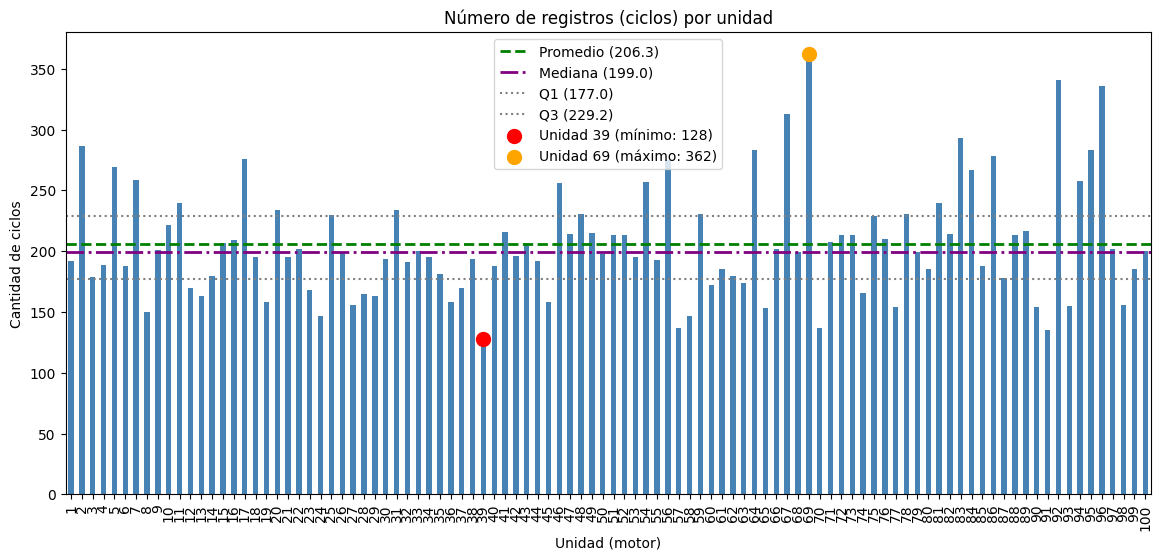

In [ ]:
# ================================#
# ANÁLISIS DE NÚMERO DE REGISTROS #
# ================================#

# 1) Total de registros y unidades
total_registros = len(df)
total_unidades = df['unidad'].nunique()

# 2) Número de registros por unidad
registros_por_unidad = df.groupby('unidad').size()

# 3) Estadísticas descriptivas
estadisticas = registros_por_unidad.describe()

# 4) Unidades con vida más corta y más larga
unidad_min = registros_por_unidad.idxmin()
unidad_max = registros_por_unidad.idxmax()
ciclos_min = registros_por_unidad.min()
ciclos_max = registros_por_unidad.max()

# Crear tabla resumen
tabla_resumen = pd.DataFrame({
    "Indicador": [
        "Total de registros",
        "Total de unidades",
        "Ciclos promedio",
        "Ciclos mínimos",
        "Unidad con menos ciclos",
        "Ciclos máximos",
        "Unidad con más ciclos",
        "Desviación estándar ciclos"
    ],
    "Valor": [
        total_registros,
        total_unidades,
        round(estadisticas['mean'], 2),
        ciclos_min,
        unidad_min,
        ciclos_max,
        unidad_max,
        round(estadisticas['std'], 2)
    ]
})
print("Total de registros y columnas: ", df.shape)
display(tabla_resumen.style.set_table_styles(
    [{'selector': 'th', 'props': [('border', '1px solid black')]},
     {'selector': 'td', 'props': [('border', '1px solid black')]}]
).set_properties(**{'text-align': 'center'}))


# ======================#
#   Gráfico por unidad  #
# ======================#

plt.figure(figsize=(14,6))
registros_por_unidad.plot(kind='bar', color='steelblue')

# Títulos
plt.title("Número de registros (ciclos) por unidad")
plt.xlabel("Unidad (motor)")
plt.ylabel("Cantidad de ciclos")

# --- Indicadores ---

# Promedio
plt.axhline(y=estadisticas['mean'], color='green', linestyle='--', linewidth=2, label=f"Promedio ({estadisticas['mean']:.1f})")

# Mediana
plt.axhline(y=estadisticas['50%'], color='purple', linestyle='-.', linewidth=2, label=f"Mediana ({estadisticas['50%']:.1f})")

# Percentiles Q1 y Q3
plt.axhline(y=estadisticas['25%'], color='grey', linestyle=':', linewidth=1.5, label=f"Q1 ({estadisticas['25%']:.1f})")
plt.axhline(y=estadisticas['75%'], color='grey', linestyle=':', linewidth=1.5, label=f"Q3 ({estadisticas['75%']:.1f})")

# Unidad con menos ciclos
plt.scatter(unidad_min-1, ciclos_min, color='red', s=100, zorder=5, label=f"Unidad {unidad_min} (mínimo: {ciclos_min})")

# Unidad con más ciclos
plt.scatter(unidad_max-1, ciclos_max, color='orange', s=100, zorder=5, label=f"Unidad {unidad_max} (máximo: {ciclos_max})")

# Leyenda
plt.legend()
plt.show()

La gráfica muestra la duración en ciclos de cada unidad del dataset FD001. Se destacan los indicadores principales: el promedio (línea verde discontinua), la mediana (línea púrpura), los percentiles 25 y 75 (líneas grises punteadas) y los valores extremos correspondientes a la unidad con menor duración (punto rojo) y la de mayor duración (punto naranja). La inclusión de estos indicadores permite observar tanto la tendencia central como la variabilidad en la vida útil de los motores, evidenciando que existen diferencias significativas entre las unidades en cuanto a su tiempo de operación hasta la falla.

La distribución del número de ciclos por unidad evidencia que cada motor presenta una duración de vida distinta antes de alcanzar la falla, con valores mínimos y máximos que varían de forma considerable. Mientras algunas unidades alcanzan la falla en pocos ciclos, otras logran operar durante un número mucho mayor de vuelos simulados. Esta variabilidad refleja que la degradación de los motores no es uniforme, lo que justifica la necesidad de aplicar técnicas de modelado predictivo que permitan anticipar el momento óptimo de intervención de manera individualizada para cada motor, en lugar de asumir un tiempo de vida estándar.

In [ ]:
#======================#
#  PERFILADO COMPLETO  #
#======================#

def _prep_numeric_df(df_num: pd.DataFrame) -> pd.DataFrame:
    """
    Limpia un DataFrame numérico para correlaciones:
    1) Convierte a numérico (si ya lo es, no cambia)
    2) Reemplaza ±Inf por NaN
    3) Elimina columnas totalmente NaN
    4) Elimina columnas con <=1 valor distinto (constantes o casi constantes)
    5) Elimina columnas con desviación estándar 0 (sobre datos disponibles)
    """
    X = df_num.select_dtypes(include=[np.number]).copy()
    # Inf -> NaN
    X = X.replace([np.inf, -np.inf], np.nan)
    # Quitar columnas totalmente NaN
    X = X.dropna(axis=1, how='all')
    # Quitar columnas con <=1 valor distinto
    nunq = X.nunique(dropna=True)
    X = X.loc[:, nunq > 1]
    if X.shape[1] == 0:
        return X
    # Quitar columnas con std = 0
    std = X.std(numeric_only=True)
    X = X.loc[:, std > 0]
    return X

def safe_corr_matrix(df_num: pd.DataFrame, min_periods: int = 2) -> pd.DataFrame:
    """
    Matriz de correlación Pearson libre de warnings:
    - Filtra columnas problemáticas con _prep_numeric_df
    - min_periods=2 evita divisiones inválidas
    """
    X = _prep_numeric_df(df_num)
    if X.shape[1] <= 1:
        return pd.DataFrame()
    corr = X.corr(min_periods=min_periods)
    return corr

def safe_corrwith_target(df_num: pd.DataFrame, target: pd.Series) -> pd.DataFrame:
    """
    Correlación (Pearson) de cada columna numérica con un objetivo (numérico o binario),
    sin warnings. Exige al menos 2 pares válidos y std>0 en ambas series.
    """
    X = _prep_numeric_df(df_num)
    y = pd.to_numeric(target, errors='coerce').replace([np.inf, -np.inf], np.nan)

    # Filas válidas del target
    mask = y.notna()
    X, y = X.loc[mask], y.loc[mask]

    if X.shape[1] == 0 or y.shape[0] < 2:
        return pd.DataFrame(columns=['correlacion'])

    cors = {}
    for col in X.columns:
        s = X[col]
        m = s.notna() & y.notna()
        if m.sum() >= 2 and s[m].std() > 0 and y[m].std() > 0:
            cors[col] = s[m].corr(y[m])
        else:
            cors[col] = np.nan

    out = pd.Series(cors, name='correlacion').sort_values(ascending=False).to_frame()
    out.index.name = 'columna'
    return out

# -------------------------------------------------------#
# Función principal: Perfilado de variables (tablas)     #
# -------------------------------------------------------#
def perfilado_variables(df: pd.DataFrame,
                        objetivo_continuo: str = 'RUL',
                        objetivo_binario: str = 'requiere_mantenimiento'):
    df_copy = df.copy()

    # 1) Tipos
    tipos = df_copy.dtypes.rename('tipo')

    # 2) Métricas base
    n_filas = len(df_copy)
    nulos = df_copy.isna().sum().rename('n_nulos')
    pct_nulos = (nulos / n_filas * 100).round(2).rename('%_nulos')
    # Conteo de ceros (solo numéricas, reindex para incluir todas)
    ceros = (df_copy == 0).sum(numeric_only=True).reindex(df_copy.columns, fill_value=0).rename('n_ceros')
    pct_ceros = ((ceros / n_filas) * 100).round(2).rename('%_ceros')
    unicos = df_copy.nunique(dropna=False).rename('n_unicos')

    # 3) Constante / casi-constante (≥95% el valor más frecuente)
    def prop_top(s: pd.Series):
        vc = s.value_counts(dropna=False)
        return (vc.iloc[0] / n_filas) if len(vc) else np.nan

    prop_mas_frecuente = df_copy.apply(prop_top).rename('prop_mas_frecuente')
    es_constante = (unicos == 1).rename('constante')
    casi_constante = (prop_mas_frecuente >= 0.95).rename('casi_constante_>=95%')

    # 4) Partición numéricas / categóricas
    numericas = df_copy.select_dtypes(include=[np.number]).columns.tolist()
    categoricas = [c for c in df_copy.columns if c not in numericas]

    # 5) Estadísticas numéricas + outliers IQR
    if numericas:
        desc_num = df_copy[numericas].describe().T
        Q1 = df_copy[numericas].quantile(0.25)
        Q3 = df_copy[numericas].quantile(0.75)
        IQR = Q3 - Q1
        low = Q1 - 1.5 * IQR
        high = Q3 + 1.5 * IQR
        outliers_cnt = ((df_copy[numericas] < low) | (df_copy[numericas] > high)).sum()
        outliers_pct = (outliers_cnt / n_filas * 100).round(2)
        desc_num['outliers_IQR'] = outliers_cnt
        desc_num['%_outliers_IQR'] = outliers_pct
        desc_num = desc_num.reset_index().rename(columns={'index': 'columna'})
    else:
        desc_num = pd.DataFrame(columns=['columna'])

    # 6) Resumen de categóricas (Top-3)
    resumen_cat_rows = []
    for c in categoricas:
        s = df_copy[c]
        vc = s.value_counts(dropna=False).head(3)
        fila = {
            'columna': c,
            'tipo': s.dtype,
            'n_unicos': s.nunique(dropna=False),
            'top1_valor': (vc.index[0] if len(vc) > 0 else np.nan),
            'top1_freq':  (int(vc.iloc[0]) if len(vc) > 0 else np.nan),
            'top2_valor': (vc.index[1] if len(vc) > 1 else np.nan),
            'top2_freq':  (int(vc.iloc[1]) if len(vc) > 1 else np.nan),
            'top3_valor': (vc.index[2] if len(vc) > 2 else np.nan),
            'top3_freq':  (int(vc.iloc[2]) if len(vc) > 2 else np.nan),
        }
        resumen_cat_rows.append(fila)
    desc_cat = pd.DataFrame(resumen_cat_rows)

    # 7) Correlaciones "seguras"
    corr_rul_tab = pd.DataFrame()
    if (objetivo_continuo in df_copy.columns and
        pd.api.types.is_numeric_dtype(df_copy[objetivo_continuo]) and len(numericas) > 0):
        corr_rul_tab = safe_corrwith_target(df_copy[numericas], df_copy[objetivo_continuo])

    corr_bin_tab = pd.DataFrame()
    if (objetivo_binario in df_copy.columns and
        pd.api.types.is_numeric_dtype(df_copy[objetivo_binario]) and len(numericas) > 0):
        corr_bin_tab = safe_corrwith_target(df_copy[numericas], df_copy[objetivo_binario])

    # 8) Tabla maestra por columna
    base = pd.concat([tipos, nulos, pct_nulos, ceros, pct_ceros, unicos,
                      es_constante, casi_constante, prop_mas_frecuente], axis=1)
    base = base.reset_index().rename(columns={'index': 'columna'})
    base = base.sort_values(by=['tipo', 'columna']).reset_index(drop=True)

    resultados = {
        'tabla_maestra_columnas': base,
        'resumen_numericas': desc_num,
        'resumen_categoricas': desc_cat,
        'correlacion_con_RUL': corr_rul_tab,
        'correlacion_con_objetivo_binario': corr_bin_tab,
        'lista_numericas': numericas,
        'lista_categoricas': categoricas
    }
    return resultados

# ---------#
# Heatmaps #
# ---------#
def heatmap_sensores_vs_RUL(df, col_obj='RUL'):
    num_df = df.select_dtypes(include=[np.number]).copy()
    if col_obj not in num_df.columns:
        print(f"[Aviso] No existe la columna objetivo continua '{col_obj}'.")
        return
    # Tomar sensores + RUL y limpiar
    cols_sens = [c for c in num_df.columns if c.startswith('sensor_')]
    X = num_df[cols_sens + [col_obj]]
    X = _prep_numeric_df(X)
    if col_obj not in X.columns:
        print(f"[Aviso] '{col_obj}' quedó fuera tras limpieza (NaN/std=0).")
        return
    corr = safe_corr_matrix(X)
    if corr.empty:
        print("[Aviso] No hay suficientes columnas válidas para correlación.")
        return
    # Orden por |corr| con RUL
    orden = corr[col_obj].abs().sort_values(ascending=False).index
    corr_plot = corr.loc[orden, [col_obj]]

    plt.figure(figsize=(6, max(8, 0.3*len(orden))))
    sns.heatmap(corr_plot, annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.title("Mapa de calor: Correlación Sensores vs RUL")
    plt.ylabel("Variables")
    plt.xlabel("")
    plt.show()

def heatmap_sensores_vs_binario(df, col_obj='requiere_mantenimiento'):
    num_df = df.select_dtypes(include=[np.number]).copy()
    if col_obj not in num_df.columns:
        print(f"[Aviso] No existe la columna objetivo binaria '{col_obj}'.")
        return
    cols_sens = [c for c in num_df.columns if c.startswith('sensor_')]
    X = num_df[cols_sens + [col_obj]]
    X = _prep_numeric_df(X)
    if col_obj not in X.columns:
        print(f"[Aviso] '{col_obj}' quedó fuera tras limpieza (NaN/std=0).")
        return
    corr = safe_corr_matrix(X)
    if corr.empty:
        print("[Aviso] No hay suficientes columnas válidas para correlación.")
        return
    orden = corr[col_obj].abs().sort_values(ascending=False).index
    corr_plot = corr.loc[orden, [col_obj]]

    plt.figure(figsize=(6, max(8, 0.3*len(orden))))
    sns.heatmap(corr_plot, annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.title("Mapa de calor: Correlación Sensores vs Requiere Mantenimiento")
    plt.ylabel("Variables")
    plt.xlabel("")
    plt.show()

def heatmap_multicolinealidad_sensores(df):
    num_df = df.select_dtypes(include=[np.number]).copy()
    cols_sens = [c for c in num_df.columns if c.startswith('sensor_')]
    if not cols_sens:
        print("[Aviso] No hay columnas 'sensor_' en el dataset.")
        return
    X = _prep_numeric_df(num_df[cols_sens])
    corr = safe_corr_matrix(X)
    if corr.empty:
        print("[Aviso] No hay suficientes columnas válidas para correlación.")
        return
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0)
    plt.title("Mapa de calor: Correlación entre Sensores (multicolinealidad)")
    plt.show()

# -------------------------------------------------------#
# Helper de presentación: tablas con bordes en Jupyter   #
# -------------------------------------------------------#
def mostrar_con_bordes(df_):
    if df_ is None or df_.empty:
        print("(Tabla vacía)")
        return
    display(
        df_.style.set_table_styles(
            [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
        ).set_properties(**{'text-align': 'center'})
    )

# =======================#
#    EJECUCIÓN COMPLETA  #
# =======================#

# 1) Perfilado (tablas)
res = perfilado_variables(df, objetivo_continuo='RUL', objetivo_binario='requiere_mantenimiento')

print("TABLA MAESTRA (estructura/calidad por columna)")
mostrar_con_bordes(res['tabla_maestra_columnas'])

print("\nRESUMEN NUMÉRICAS (describe + outliers IQR)")
mostrar_con_bordes(res['resumen_numericas'])

print("\nRESUMEN CATEGÓRICAS (Top-3 frecuencias)")
mostrar_con_bordes(res['resumen_categoricas'])




TABLA MAESTRA (estructura/calidad por columna)


,columna,tipo,n_nulos,%_nulos,n_ceros,%_ceros,n_unicos,constante,casi_constante_>=95%,prop_mas_frecuente
0,RUL,int64,0,0.000000,100,0.480000,362,False,False,0.004847
1,ciclo,int64,0,0.000000,0,0.000000,362,False,False,0.004847
2,ciclo_maximo,int64,0,0.000000,0,0.000000,66,False,False,0.051621
3,requiere_mantenimiento,int64,0,0.000000,17531,84.970000,2,False,False,0.849741
4,sensor_17,int64,0,0.000000,0,0.000000,13,False,False,0.263923
5,sensor_18,int64,0,0.000000,0,0.000000,1,True,True,1.000000
6,unidad,int64,0,0.000000,0,0.000000,100,False,False,0.017546
7,ajuste_op_1,float64,0,0.000000,413,2.000000,158,False,False,0.020018
8,ajuste_op_2,float64,0,0.000000,2070,10.030000,13,False,False,0.101982
9,ajuste_op_3,float64,0,0.000000,0,0.000000,1,True,True,1.000000



RESUMEN NUMÉRICAS (describe + outliers IQR)


,columna,count,mean,std,min,25%,50%,75%,max,outliers_IQR,%_outliers_IQR
0,unidad,20631.000000,51.506568,29.227633,1.000000,26.000000,52.000000,77.000000,100.000000,0,0.000000
1,ciclo,20631.000000,108.807862,68.880990,1.000000,52.000000,104.000000,156.000000,362.000000,104,0.500000
2,ajuste_op_1,20631.000000,-0.000009,0.002187,-0.008700,-0.001500,0.000000,0.001500,0.008700,105,0.510000
3,ajuste_op_2,20631.000000,0.000002,0.000293,-0.000600,-0.000200,0.000000,0.000300,0.000600,0,0.000000
4,ajuste_op_3,20631.000000,100.000000,0.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0,0.000000
5,sensor_1,20631.000000,518.670000,0.000000,518.670000,518.670000,518.670000,518.670000,518.670000,0,0.000000
6,sensor_2,20631.000000,642.680934,0.500053,641.210000,642.325000,642.640000,643.000000,644.530000,128,0.620000
7,sensor_3,20631.000000,1590.523119,6.131150,1571.040000,1586.260000,1590.100000,1594.380000,1616.910000,165,0.800000
8,sensor_4,20631.000000,1408.933782,9.000605,1382.250000,1402.360000,1408.040000,1414.555000,1441.490000,120,0.580000
9,sensor_5,20631.000000,14.620000,0.000000,14.620000,14.620000,14.620000,14.620000,14.620000,0,0.000000



RESUMEN CATEGÓRICAS (Top-3 frecuencias)
(Tabla vacía)


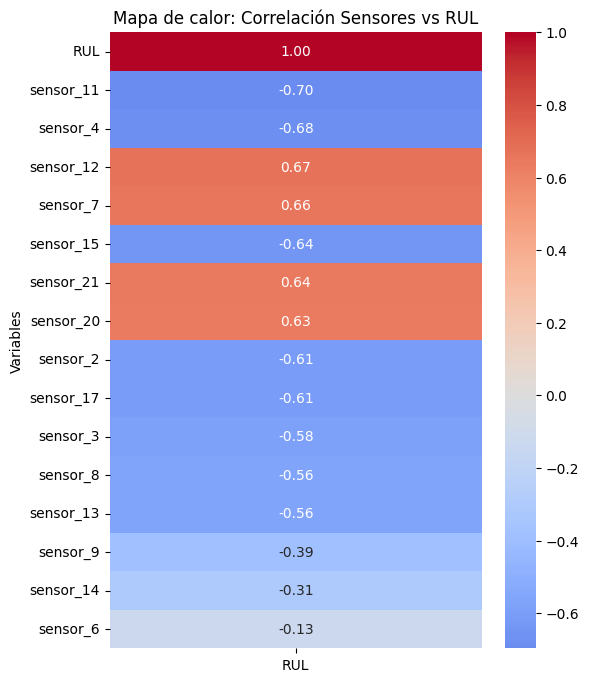

In [ ]:
# 2) Heatmaps (correlación)
heatmap_sensores_vs_RUL(df, col_obj='RUL')



El análisis de correlación evidencia que los sensores relacionados con la dinámica térmica y de presión del motor son los más informativos respecto a la vida útil restante (RUL). En particular, la temperatura de entrada al compresor de alta (sensor 11), la presión de salida de la turbina de baja (sensor 4), la presión y temperatura en el compresor de alta (sensores 12 y 7), la temperatura de salida de la cámara de combustión (sensor 15), la temperatura de los gases de escape (sensor 21) y la relación de velocidad del núcleo (sensor 20) presentan correlaciones absolutas superiores a 0.60. Estos parámetros reflejan de manera directa el deterioro progresivo del motor, por lo que constituyen variables clave en la construcción del modelo predictivo. En contraste, sensores como la presión del conducto de bypass (sensor 6) o la relación aire-combustible (sensor 14) muestran una relación débil con el RUL, indicando una contribución limitada al modelo.

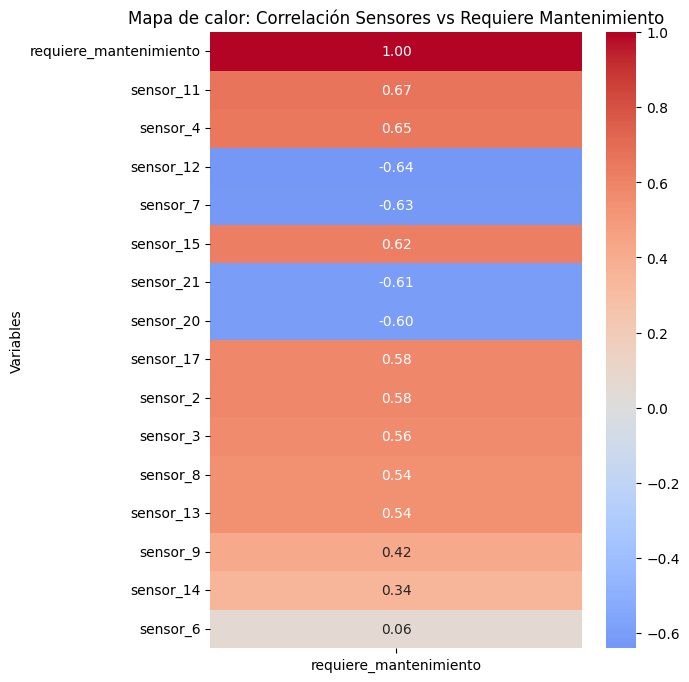

In [ ]:
heatmap_sensores_vs_binario(df, col_obj='requiere_mantenimiento')


El análisis de correlación entre los sensores y la variable binaria de mantenimiento revela que los parámetros termodinámicos y de presión del motor constituyen los principales predictores de falla. En particular, la temperatura de entrada al compresor de alta (sensor 11), la presión de salida de la turbina de baja (sensor 4), la presión y temperatura en el compresor (sensores 12 y 7), la temperatura de la cámara de combustión (sensor 15), la temperatura de los gases de escape (sensor 21) y la relación de velocidad del núcleo (sensor 20) presentan correlaciones absolutas cercanas o superiores a 0.60. Esto confirma que dichas variables son determinantes en la clasificación de equipos que requieren mantenimiento. Por el contrario, parámetros como la presión en el conducto de bypass (sensor 6) muestran escasa relación con la condición de mantenimiento, por lo que su relevancia en el modelo predictivo es limitada

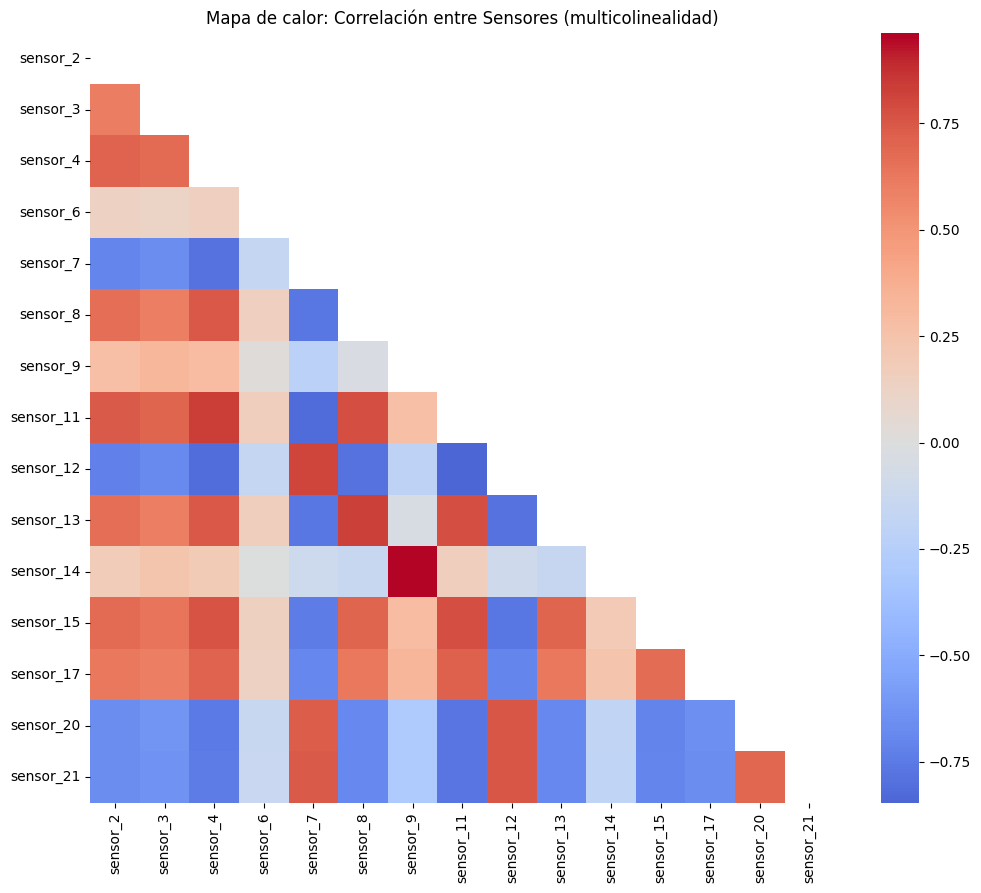

In [ ]:
heatmap_multicolinealidad_sensores(df)



El análisis de correlación entre sensores muestra la existencia de bloques de variables altamente relacionadas, lo que evidencia multicolinealidad. Destacan las fuertes asociaciones entre el sensor 14 (relación aire-combustible) y el sensor 9 (velocidad del ventilador), así como entre los sensores de temperatura en distintas etapas del motor: sensor 7 (salida LPC), sensor 8 (salida HPC), sensor 15 (salida de combustión) y sensor 21 (gases de escape). De manera similar, los sensores de presión en el compresor y la turbina (sensores 2, 4 y 12) muestran correlaciones elevadas. Estas redundancias, aunque esperables desde el punto de vista físico, refuerzan la necesidad de aplicar técnicas de reducción de dimensionalidad como PCA, que permitan disminuir la multicolinealidad y optimizar el desempeño del modelo predictivo

In [ ]:
# 3) Rankings de correlación como tablas
rank_corr_rul = safe_corrwith_target(df.select_dtypes(include=[np.number]), df['RUL']) \
                if 'RUL' in df.columns else pd.DataFrame()
rank_corr_bin = safe_corrwith_target(df.select_dtypes(include=[np.number]), df['requiere_mantenimiento']) \
                if 'requiere_mantenimiento' in df.columns else pd.DataFrame()

print("\nRANKING (tabla): Correlación con RUL (|mayor→menor|)")
mostrar_con_bordes(rank_corr_rul.reindex(rank_corr_rul['correlacion'].abs().sort_values(ascending=False).index)
                   if not rank_corr_rul.empty else pd.DataFrame())

print("\nRANKING (tabla): Correlación con Requiere Mantenimiento (|mayor→menor|)")
mostrar_con_bordes(rank_corr_bin.reindex(rank_corr_bin['correlacion'].abs().sort_values(ascending=False).index)
                   if not rank_corr_bin.empty else pd.DataFrame())

# 4) (Opcional) Exportar a Excel
# with pd.ExcelWriter("Perfilado_Variables_CMAPPSS.xlsx", engine="xlsxwriter") as writer:
#     res['tabla_maestra_columnas'].to_excel(writer, sheet_name="00_Estructura", index=False)
#     res['resumen_numericas'].to_excel(writer, sheet_name="01_Numericas", index=False)
#     res['resumen_categoricas'].to_excel(writer, sheet_name="02_Categoricas", index=False)
#     rank_corr_rul.to_excel(writer, sheet_name="03_Ranking_Corr_RUL")
#     rank_corr_bin.to_excel(writer, sheet_name="04_Ranking_Corr_Bin")


RANKING (tabla): Correlación con RUL (|mayor→menor|)


,correlacion
columna,
RUL,1.000000
ciclo,-0.736241
sensor_11,-0.696228
sensor_4,-0.678948
sensor_12,0.671983
sensor_7,0.657223
sensor_15,-0.642667
sensor_21,0.635662
sensor_20,0.629428



RANKING (tabla): Correlación con Requiere Mantenimiento (|mayor→menor|)


,correlacion
columna,
requiere_mantenimiento,1.000000
sensor_11,0.665655
sensor_4,0.648406
sensor_12,-0.640174
sensor_7,-0.625592
sensor_15,0.618732
sensor_21,-0.606480
sensor_20,-0.599912
sensor_17,0.583067


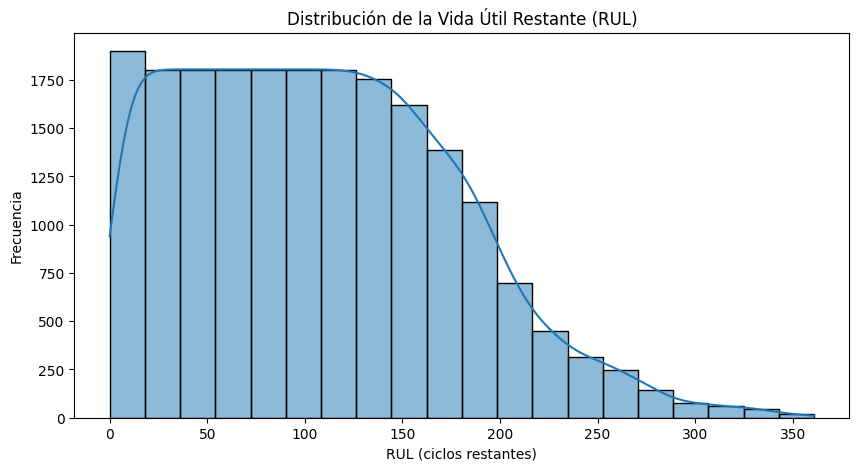

In [ ]:
# ======================#
# EXPLORACIÓN DE DATOS  #
# ======================#

# 1) Distribución de RUL
plt.figure(figsize=(10,5))
sns.histplot(df['RUL'], bins=20, kde=True)
plt.title("Distribución de la Vida Útil Restante (RUL)")
plt.xlabel("RUL (ciclos restantes)")
plt.ylabel("Frecuencia")
plt.show()



Esta distribución es coherente con la lógica de un sistema en degradación: cada motor genera múltiples lecturas a lo largo de su ciclo de vida, por lo que es más común encontrar registros cuando la máquina ya ha consumido parte importante de su vida útil que al inicio de la operación. Este comportamiento justifica la importancia de modelos predictivos, ya que gran parte de los datos disponibles corresponden a situaciones críticas cercanas al fallo, donde anticipar la intervención es más valioso.

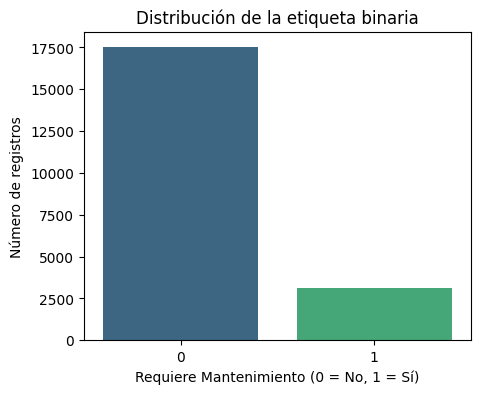

In [ ]:
# 2) Distribución de la variable objetivo
plt.figure(figsize=(5,4))
sns.countplot(
    x='requiere_mantenimiento',
    data=df,
    hue='requiere_mantenimiento',  # usar la misma variable para el color
    palette='viridis',
    legend=False
)
plt.title("Distribución de la etiqueta binaria")
plt.xlabel("Requiere Mantenimiento (0 = No, 1 = Sí)")
plt.ylabel("Número de registros")
plt.show()



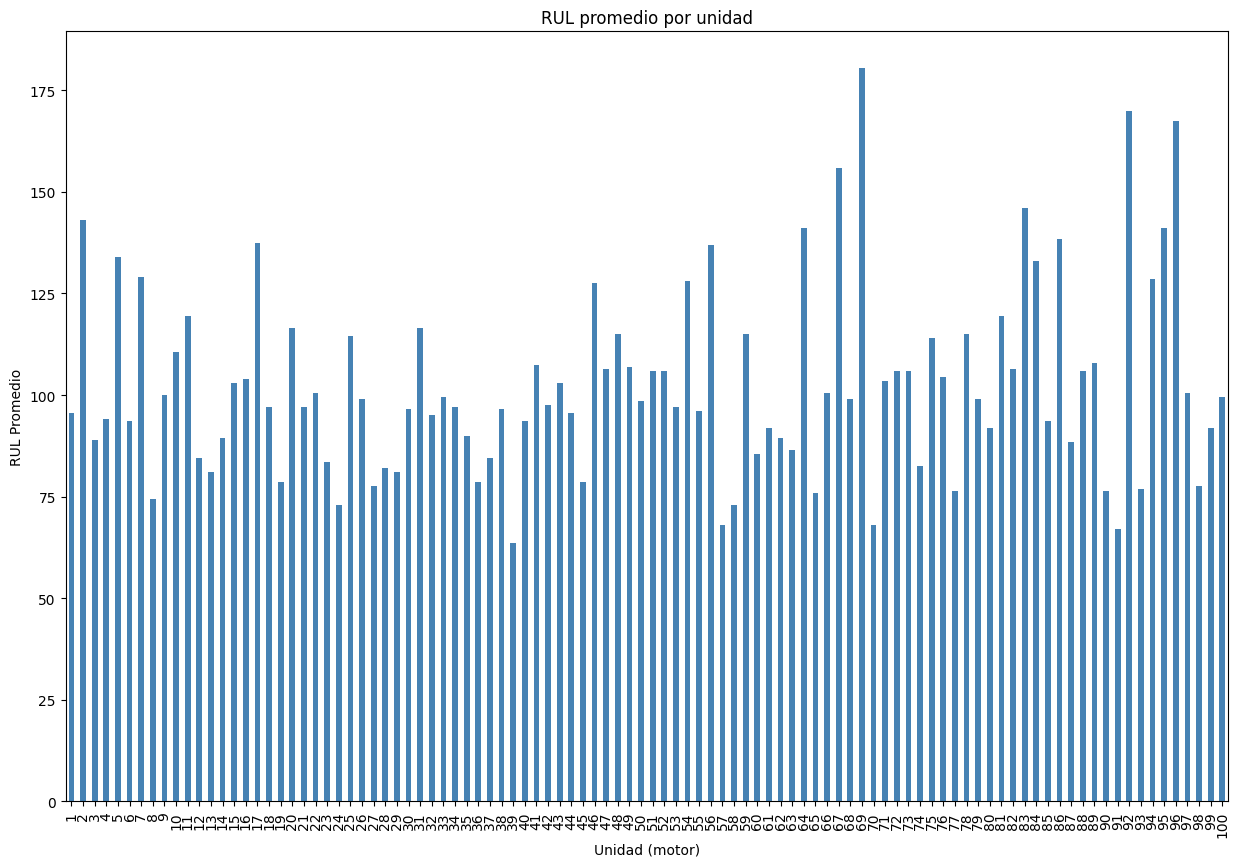

In [ ]:
# 3) RUL promedio por unidad
rul_promedio = df.groupby('unidad')['RUL'].mean()
plt.figure(figsize=(15,10))
rul_promedio.plot(kind='bar', color='steelblue')
plt.title("RUL promedio por unidad")
plt.xlabel("Unidad (motor)")
plt.ylabel("RUL Promedio")
plt.show()



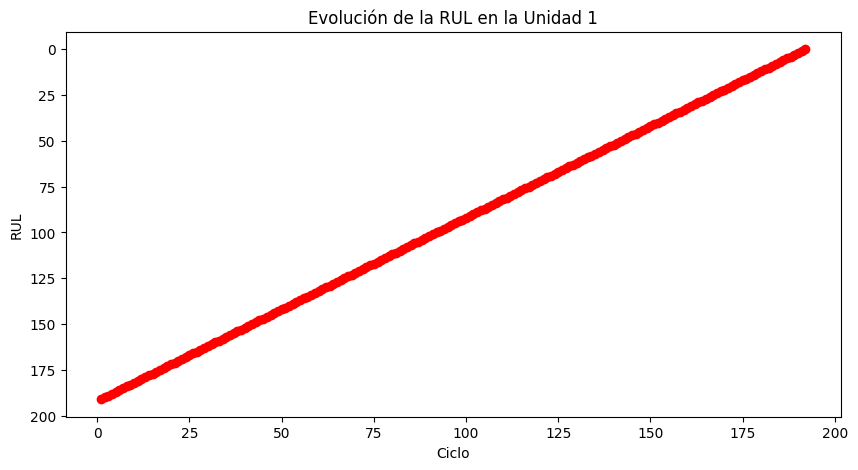

In [ ]:
# 4) Ejemplo de evolución de RUL en una unidad específica
unidad_ejemplo = 1
df_unidad = df[df['unidad'] == unidad_ejemplo]

plt.figure(figsize=(10,5))
plt.plot(df_unidad['ciclo'], df_unidad['RUL'], marker='o', linestyle='-', color='red')
plt.title(f"Evolución de la RUL en la Unidad {unidad_ejemplo}")
plt.xlabel("Ciclo")
plt.ylabel("RUL")
plt.gca().invert_yaxis()  # opcional, para que 0 quede abajo
plt.show()



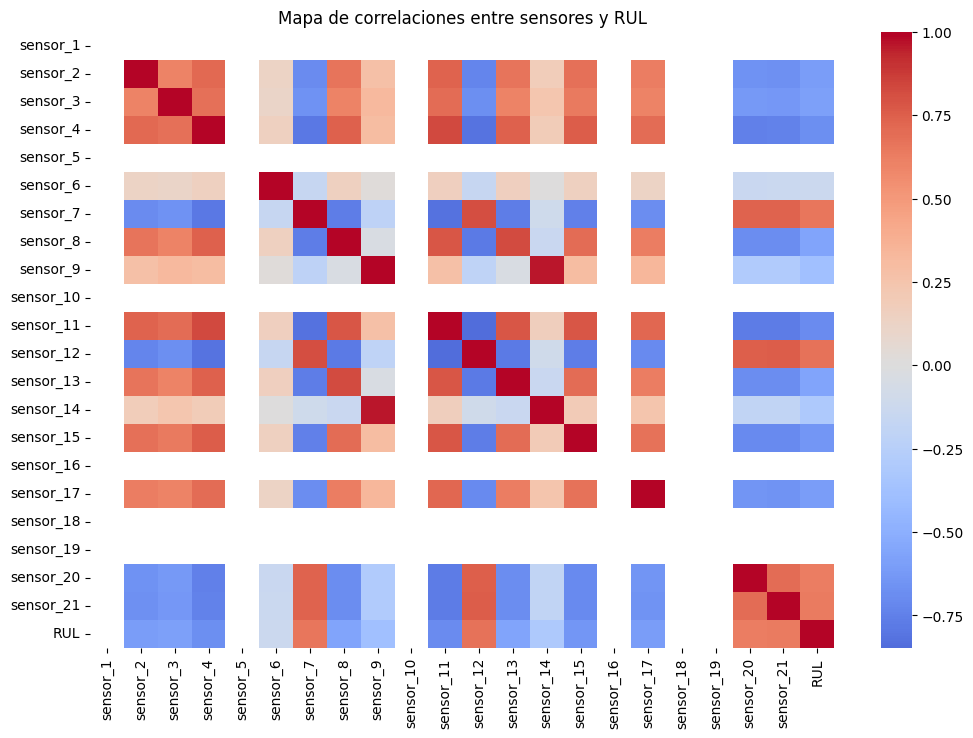

In [ ]:
# 5) Correlación entre sensores y RUL (primer vistazo)
plt.figure(figsize=(12,8))
corr = df[[c for c in df.columns if c.startswith('sensor_')] + ['RUL']].corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Mapa de correlaciones entre sensores y RUL")
plt.show()

El mapa de correlaciones entre sensores y con el RUL permite identificar relaciones clave en el comportamiento del motor. Se observan fuertes correlaciones positivas entre los sensores de presión (2, 3 y 4) y entre los sensores de temperatura en diferentes etapas (15 y 21), lo que refleja la coherencia física del sistema. Asimismo, la correlación de algunos sensores con el RUL, como la temperatura de entrada al compresor de alta (sensor 11) o la presión de salida de la turbina de baja (sensor 4), confirma su relevancia como predictores de degradación. Sin embargo, la presencia de bloques de alta correlación evidencia multicolinealidad, lo que hace necesario aplicar técnicas de reducción de dimensionalidad para evitar redundancias en el modelo predictivo

Variables clave para EDA (fuente: Varianza): ['sensor_9', 'sensor_14', 'sensor_4', 'sensor_3', 'sensor_17', 'sensor_7', 'sensor_12', 'sensor_2', 'sensor_11', 'sensor_20', 'sensor_21', 'sensor_13']


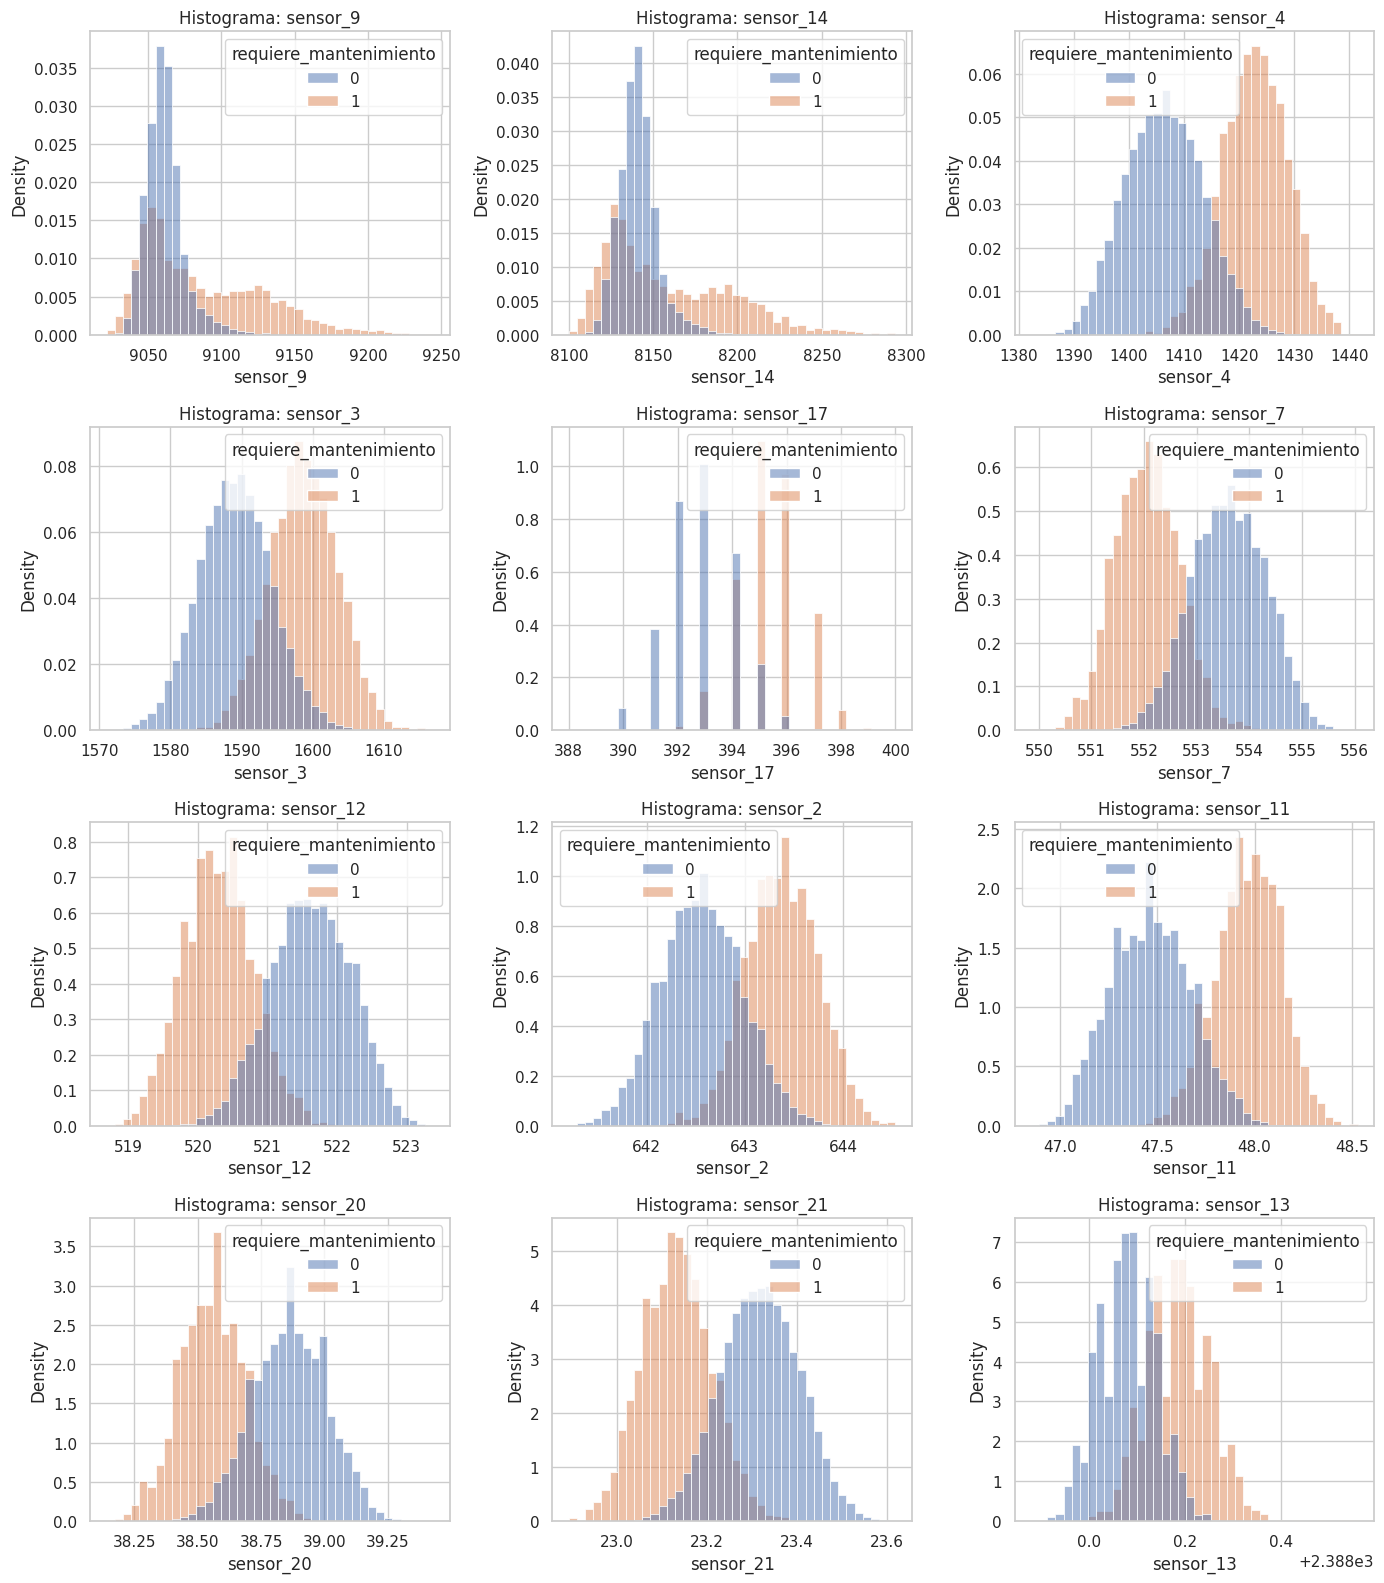

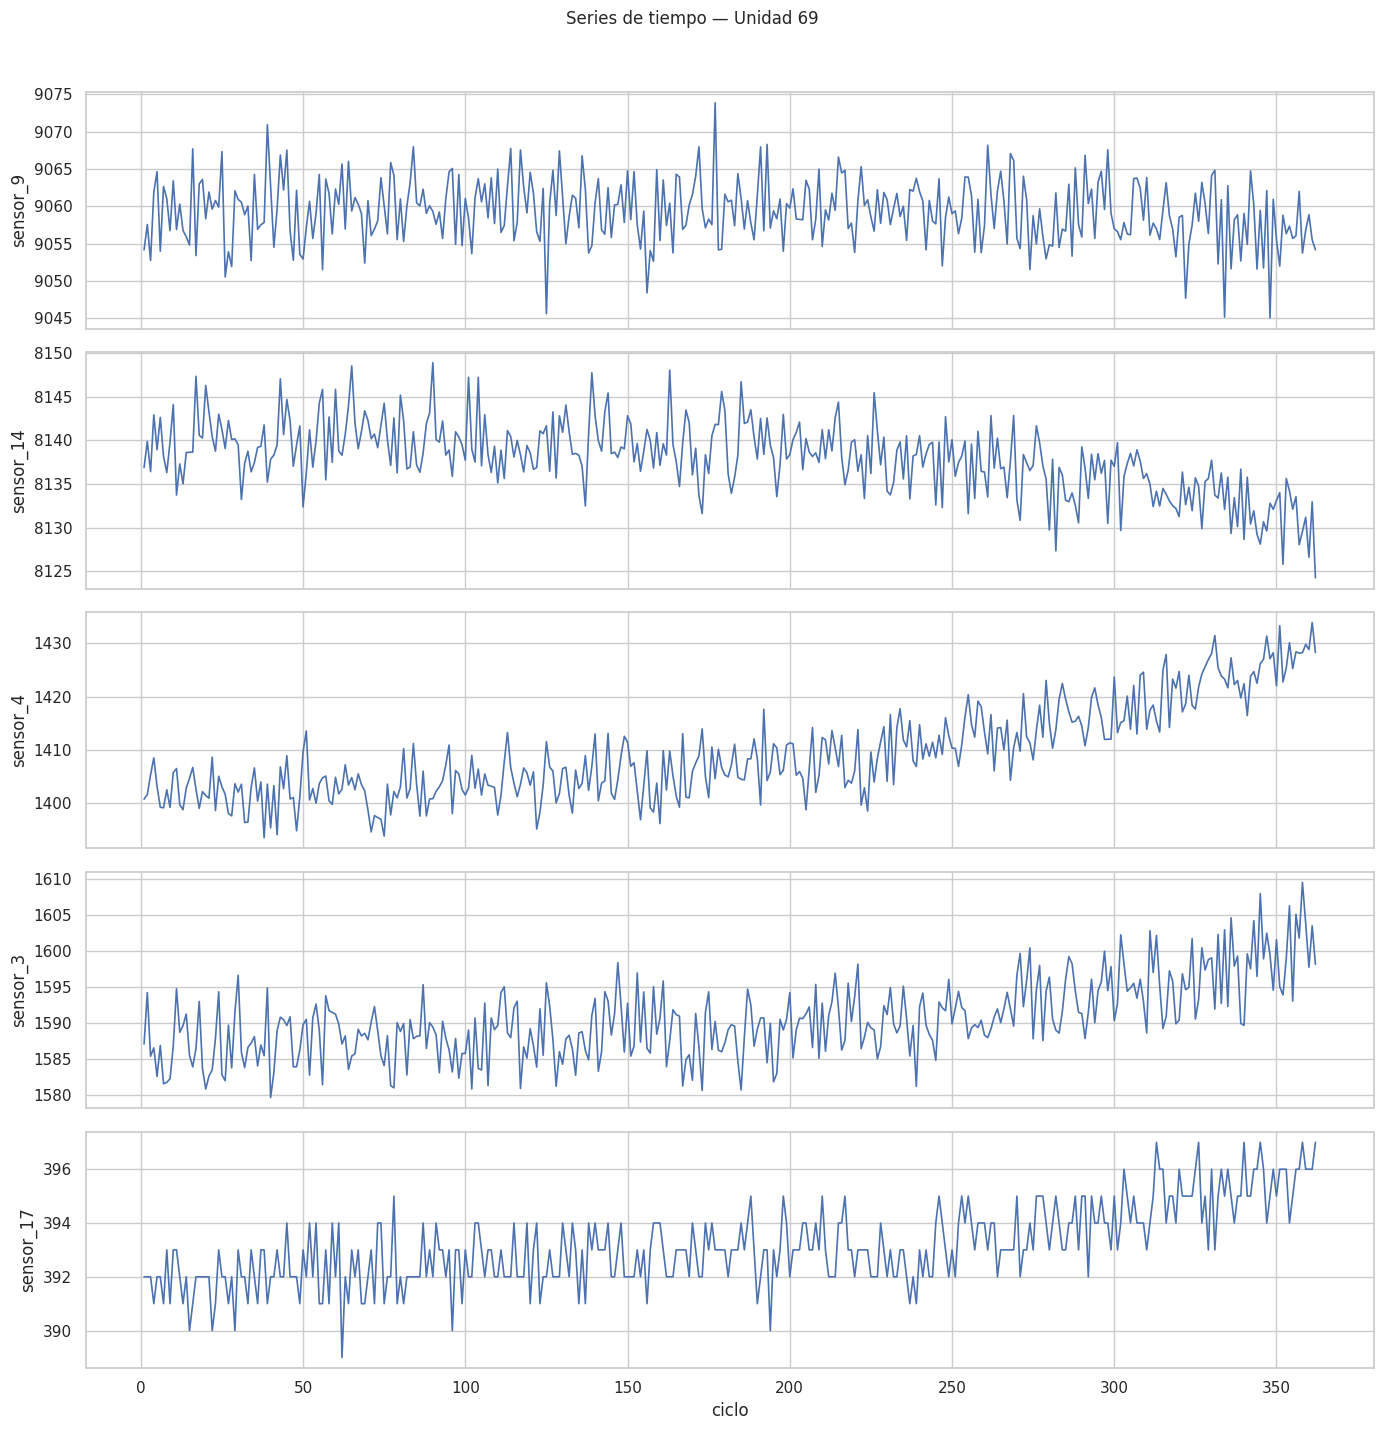

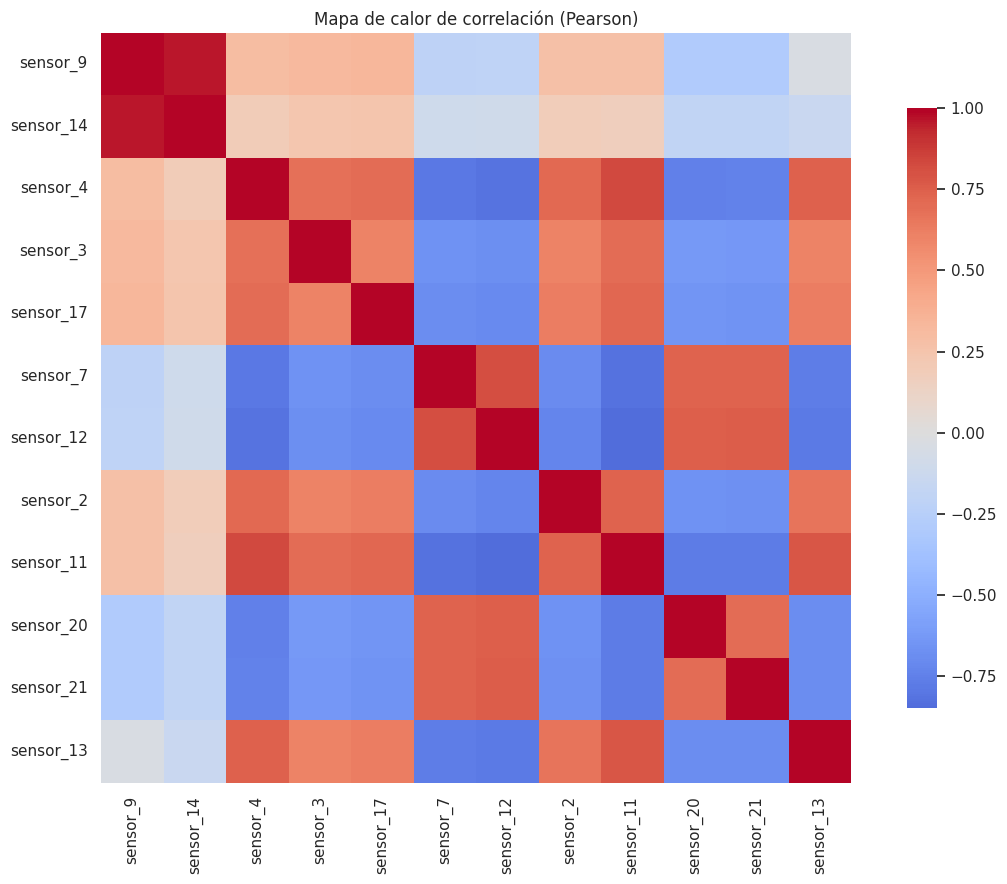

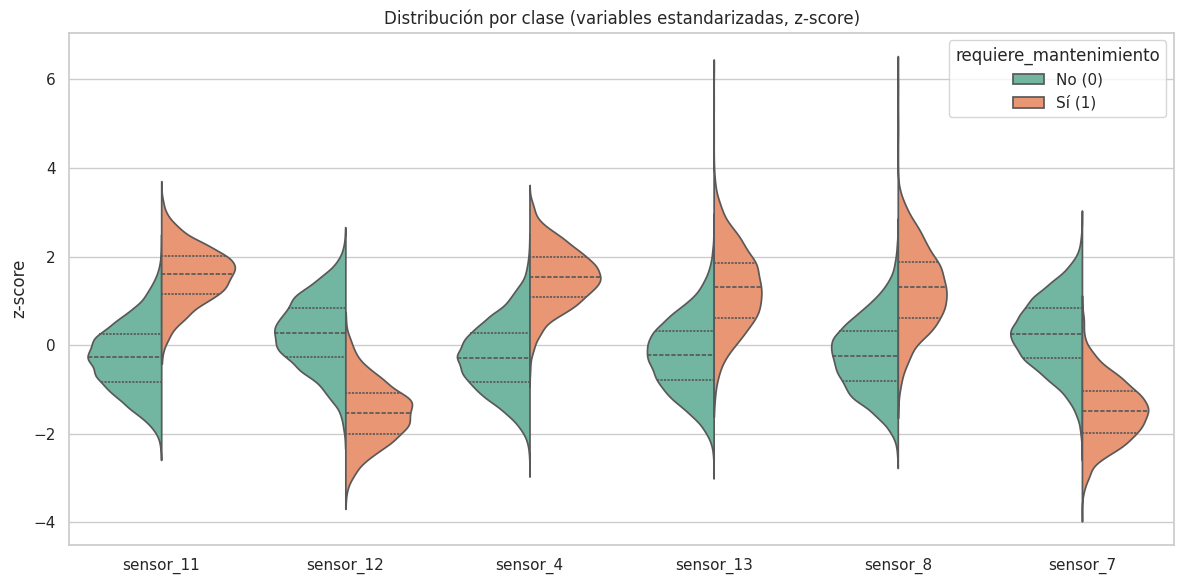

=== RESUMEN DE VARIANZA ===


,Indicador,Valor
0,Sensores iniciales,21
1,Sensores útiles tras varianza,15


=== VARIABLES DESCARTADAS (por varianza/constante) ===


,sensor,varianza,n_unicos,conservada,motivo
18,sensor_19,0.000000,1,False,Descartada: constante (n_unicos ≤ 1)
17,sensor_18,0.000000,1,False,Descartada: constante (n_unicos ≤ 1)
15,sensor_16,0.000000,1,False,Descartada: constante (n_unicos ≤ 1)
9,sensor_10,0.000000,1,False,Descartada: constante (n_unicos ≤ 1)
4,sensor_5,0.000000,1,False,Descartada: constante (n_unicos ≤ 1)
0,sensor_1,0.000000,1,False,Descartada: constante (n_unicos ≤ 1)


=== VARIABLES CONSERVADAS (primeras 20 por varianza) ===


,sensor,varianza,n_unicos,conservada,motivo
5,sensor_6,0.000002,2,True,Conservada (varianza > umbral)
14,sensor_15,0.001407,1918,True,Conservada (varianza > umbral)
7,sensor_8,0.005039,53,True,Conservada (varianza > umbral)
12,sensor_13,0.005172,56,True,Conservada (varianza > umbral)
20,sensor_21,0.011718,4745,True,Conservada (varianza > umbral)
19,sensor_20,0.032668,120,True,Conservada (varianza > umbral)
10,sensor_11,0.071332,159,True,Conservada (varianza > umbral)
1,sensor_2,0.250041,310,True,Conservada (varianza > umbral)
11,sensor_12,0.543959,427,True,Conservada (varianza > umbral)
6,sensor_7,0.783350,513,True,Conservada (varianza > umbral)


=== DIVISIÓN DE DATOS POR UNIDAD ===


,Conjunto,Filas,Columnas
0,Train,16561,15
1,Test,4070,15


=== DISTRIBUCIÓN DE LA ETIQUETA (antes y después de SMOTE) ===


,Clase,Train antes (#),Train antes (%),Test antes (#),Test antes (%),Train SMOTE (#)
0,No (0),14081,85.03,3450,84.77,14081
1,Sí (1),2480,14.97,620,15.23,14081


=== RESUMEN PCA ===


,Indicador,Valor
0,Componentes PCA retenidos,9
1,Varianza explicada acumulada (%),95.61


=== TOP-20 SENSORES POR APORTE ABSOLUTO MEDIO A PCA ===


,sensor,aporte_abs_medio
0,sensor_20,0.254000
1,sensor_15,0.239700
2,sensor_21,0.228800
3,sensor_3,0.218300
4,sensor_17,0.215900
5,sensor_2,0.170500
6,sensor_4,0.157700
7,sensor_6,0.124100
8,sensor_9,0.106800
9,sensor_14,0.104800


=== MATRICES FINALES PARA MODELADO ===


,Matriz,Forma
0,X_train_pca,"(28162, 9)"
1,y_train_bal,"(28162,)"
2,X_test_pca,"(4070, 9)"
3,y_test,"(4070,)"


=== VALIDACIÓN CRUZADA k=5 (media ± DE) — Pipeline completo por unidad ===


,Métrica,Media,STD
0,ROC_AUC,0.989400,0.000600
1,PR_AUC,0.950600,0.004500


In [ ]:
# ====================================#
# PREPROCESAMIENTO PARA ENTRENAMIENTO #
# ====================================#



# --------------------------------------------------
# Helper: mostrar DataFrame con bordes (estilo tesis)
# --------------------------------------------------
def show(df, title):
    print(f"=== {title} ===")
    display(
        df.style.set_table_styles(
            [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
        ).set_properties(**{'text-align': 'center'})
    )

# -------------------------
# 1) Definir features y target
# -------------------------
sensores = [c for c in df.columns if c.startswith('sensor_')]
ajustes  = [c for c in df.columns if c.startswith('ajuste_op_')]
features = sensores
target   = 'requiere_mantenimiento'
grupos   = df['unidad']

X = df[features].copy()
y = df[target].astype(int).copy()

# ===== EDA para tesis: hist, series, correlación y boxplots =====


# --- columnas y helpers ---
target = "requiere_mantenimiento"
sensores = [c for c in df.columns if c.startswith("sensor_")]
cols_keep_eda = sensores  # tras tu filtrado de varianza pueden ser menos

# Top variables para mostrar: usa SHAP si existe; si no, usa varianza
try:
    # Si seguiste nuestra sección SHAP, tendrás shap_mean con 'variable' y 'shap_abs_mean'
    top_vars = (
        shap_mean.sort_values("shap_abs_mean", ascending=False)["variable"]
        .tolist()
    )[:12]
    fuente_top = "SHAP (importancia global)"
except Exception:
    top_vars = (
        df[cols_keep_eda].var().sort_values(ascending=False).index.tolist()
    )[:12]
    fuente_top = "Varianza"

print(f"Variables clave para EDA (fuente: {fuente_top}): {top_vars}")

os.makedirs("figuras_eda", exist_ok=True)

# ---------- 1) HISTOGRAMAS (distribuciones) ----------
n = min(12, len(top_vars))
ncols = 3
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4*nrows))
axes = axes.ravel()

for i, col in enumerate(top_vars[:n]):
    ax = axes[i]
    sns.histplot(data=df, x=col, hue=target, bins=40, stat="density", common_norm=False, ax=ax)
    ax.set_title(f"Histograma: {col}")
for j in range(i+1, nrows*ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("figuras_eda/eda_histogramas.png", dpi=160)
plt.show()

# ---------- 2) SERIES DE TIEMPO POR UNIDAD ----------
# intentamos detectar la columna temporal
cand_t = [c for c in df.columns if c.lower() in ("ciclo","cycle","time","timestamp","tiempo")]
time_col = cand_t[0] if cand_t else None

# elegimos una unidad representativa (la de mayor cantidad de registros)
if "unidad" in df.columns:
    unidad_top = df["unidad"].value_counts().idxmax()
    df_u = df[df["unidad"] == unidad_top].copy()
    subt = f"Unidad {unidad_top}"
else:
    df_u = df.copy()
    subt = "Muestra global (sin columna unidad)"

# orden temporal
if time_col is not None:
    df_u = df_u.sort_values(time_col)
    x = df_u[time_col].values
    xtitle = time_col
else:
    df_u = df_u.reset_index(drop=True)
    x = df_u.index.values
    xtitle = "indice"

sel_series = top_vars[:5]  # para no saturar la figura
fig, axes = plt.subplots(len(sel_series), 1, figsize=(14, 2.8*len(sel_series)), sharex=True)
if len(sel_series) == 1:
    axes = [axes]

for ax, col in zip(axes, sel_series):
    ax.plot(x, df_u[col].values, linewidth=1.2)
    ax.set_ylabel(col)
axes[-1].set_xlabel(xtitle)
fig.suptitle(f"Series de tiempo — {subt}", y=1.02, fontsize=12)
plt.tight_layout()
plt.savefig("figuras_eda/eda_series_tiempo.png", dpi=160, bbox_inches="tight")
plt.show()

# ---------- 3) MAPA DE CALOR DE CORRELACIÓN ----------
# usamos un subconjunto para legibilidad (top 15)
sub_corr = top_vars[:15]
corr = df[sub_corr].corr(method="pearson")
plt.figure(figsize=(12, 9))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, square=True, cbar_kws={"shrink": .8})
plt.title("Mapa de calor de correlación (Pearson)")
plt.tight_layout()
plt.savefig("figuras_eda/eda_correlacion.png", dpi=160)
plt.show()

# ---------- 4) VIOLINPLOTS POR CLASE (recomendado) ----------
sns.set(style="whitegrid")

target = "requiere_mantenimiento"
vars_plot = ["sensor_11","sensor_12","sensor_4","sensor_13","sensor_8","sensor_7"]  # ajusta

tmp = df[[target] + vars_plot].copy()
# z-score por variable para comparabilidad
for c in vars_plot:
    tmp[c] = (tmp[c] - tmp[c].mean()) / (tmp[c].std() + 1e-9)

m = tmp.melt(id_vars=target, var_name="variable", value_name="z")
m[target] = m[target].map({0:"No (0)",1:"Sí (1)"})

plt.figure(figsize=(12,6))
sns.violinplot(data=m, x="variable", y="z", hue=target,
               split=True, inner="quartile", palette="Set2", cut=0)
plt.title("Distribución por clase (variables estandarizadas, z-score)")
plt.xlabel(""); plt.ylabel("z-score")
plt.tight_layout(); plt.show()






# -------------------------------------------------------#
# 2) Eliminar sensores sin variación (ruido/constantes)  #
# -------------------------------------------------------#
umbral_var = 1e-8
sel = VarianceThreshold(threshold=umbral_var)
X_var = sel.fit_transform(X)
cols_keep = [col for col, keep in zip(features, sel.get_support()) if keep]
X = pd.DataFrame(X_var, columns=cols_keep, index=df.index)

# Auditoría de varianza (con motivo)
tabla_varianza = pd.DataFrame({
    "sensor": features,
    "varianza": df[features].var(ddof=0).values,
    "n_unicos": df[features].nunique(dropna=False).values,
    "conservada": [col in cols_keep for col in features]
})
tabla_varianza["motivo"] = np.where(
    tabla_varianza["conservada"],
    "Conservada (varianza > umbral)",
    np.where(tabla_varianza["n_unicos"] <= 1,
             "Descartada: constante (n_unicos ≤ 1)",
             f"Descartada: varianza ≤ {umbral_var:g}")
)

# >>> NUEVO: Resumen antes/después (que echabas de menos)
resumen_varianza = pd.DataFrame({
    "Indicador": ["Sensores iniciales", "Sensores útiles tras varianza"],
    "Valor":     [len(features), len(cols_keep)]
})

descartadas = tabla_varianza[~tabla_varianza["conservada"]].sort_values("varianza")
conservadas = tabla_varianza[ tabla_varianza["conservada"]].sort_values("varianza")

show(resumen_varianza, "RESUMEN DE VARIANZA")
show(descartadas.round({"varianza": 6}), "VARIABLES DESCARTADAS (por varianza/constante)")
show(conservadas.round({"varianza": 6}).head(20), "VARIABLES CONSERVADAS (primeras 20 por varianza)")

# -----------------------------------------------------------#
# 3) División ENTRENAMIENTO/PRUEBA sin fuga (por unidades)   #
# -----------------------------------------------------------#
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=grupos))

X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
y_train, y_test = y.iloc[train_idx].copy(), y.iloc[test_idx].copy()

tabla_split = pd.DataFrame({
    "Conjunto": ["Train", "Test"],
    "Filas":    [X_train.shape[0], X_test.shape[0]],
    "Columnas": [X_train.shape[1], X_test.shape[1]],
})
show(tabla_split, "DIVISIÓN DE DATOS POR UNIDAD")

# ---------------------------------------------#
# 4) Escalado Min-Max (fit SOLO en entrenamiento)
# ---------------------------------------------#
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ------------------------------------------------------#
# 5) Balanceo de clases con SMOTE (solo entrenamiento)  #
# ------------------------------------------------------#
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

tabla_clases = pd.DataFrame({
    "Clase": ["No (0)", "Sí (1)"],
    "Train antes (#)": [(y_train==0).sum(), (y_train==1).sum()],
    "Train antes (%)": [f"{(y_train==0).mean()*100:.2f}", f"{(y_train==1).mean()*100:.2f}"],
    "Test  antes (#)": [(y_test==0).sum(), (y_test==1).sum()],
    "Test  antes (%)": [f"{(y_test==0).mean()*100:.2f}", f"{(y_test==1).mean()*100:.2f}"],
    "Train SMOTE (#)": [(y_train_bal==0).sum(), (y_train_bal==1).sum()]
})
show(tabla_clases, "DISTRIBUCIÓN DE LA ETIQUETA (antes y después de SMOTE)")

# --------------------------------------------------------#
# 6) Reducción de dimensionalidad con PCA (≥95% varianza) #
# --------------------------------------------------------#
pca = PCA(n_components=0.95, svd_solver='full', random_state=42)
X_train_pca = pca.fit_transform(X_train_bal)
X_test_pca  = pca.transform(X_test_scaled)

tabla_pca = pd.DataFrame({
    "Indicador": ["Componentes PCA retenidos", "Varianza explicada acumulada (%)"],
    "Valor": [X_train_pca.shape[1], f"{pca.explained_variance_ratio_.sum()*100:.2f}"]
})
show(tabla_pca, "RESUMEN PCA")

# (Opcional informativo) Aportes de cada sensor a PCA
loadings = pd.DataFrame(pca.components_, columns=cols_keep)
aporte_abs_medio = loadings.abs().mean(axis=0).sort_values(ascending=False)
tabla_aportes = aporte_abs_medio.rename("aporte_abs_medio").reset_index().rename(columns={"index":"sensor"})
show(tabla_aportes.head(20).round(4), "TOP-20 SENSORES POR APORTE ABSOLUTO MEDIO A PCA")

# -------------------------------------------------#
# 7) Resumen final de matrices listas para modelar #
# -------------------------------------------------#
tabla_final = pd.DataFrame({
    "Matriz": ["X_train_pca", "y_train_bal", "X_test_pca", "y_test"],
    "Forma":  [str(X_train_pca.shape), str(y_train_bal.shape),
               str(X_test_pca.shape),  str(y_test.shape)]
})
show(tabla_final, "MATRICES FINALES PARA MODELADO")

# === VALIDACIÓN CRUZADA K=5 (por unidad, sin fuga) ===

CLF_CV = MLPClassifier(hidden_layer_sizes=(64, 32), activation="relu", solver="adam",
                       alpha=1e-3, learning_rate_init=5e-4,
                       early_stopping=True, n_iter_no_change=10,
                       validation_fraction=0.1, max_iter=600, random_state=42)
# CLF_CV = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)  # <- alternativo

pipe_cv = Pipeline(steps=[
    ('var', VarianceThreshold(threshold=1e-8)),
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state=42)),                     # aplica SMOTE SOLO dentro de cada fold de train
    ('pca', PCA(n_components=0.95, svd_solver='full', random_state=42)),
    ('clf', CLF_CV)
])

# CV estratificada por unidad (si no está disponible, usar GroupKFold)
try:
    cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
except Exception:
    cv = GroupKFold(n_splits=5)

scoring = ['roc_auc', 'average_precision']  # PR-AUC = average_precision

cv_res = cross_validate(
    estimator=pipe_cv,
    X=df[features],
    y=df[target].astype(int).values,
    groups=df['unidad'].values,
    cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False
)

cv_tabla = pd.DataFrame({
    "Métrica": ["ROC_AUC", "PR_AUC"],
    "Media":  [cv_res['test_roc_auc'].mean(),           cv_res['test_average_precision'].mean()],
    "STD":    [cv_res['test_roc_auc'].std(),            cv_res['test_average_precision'].std()]
}).round(4)

show(cv_tabla, "VALIDACIÓN CRUZADA k=5 (media ± DE) — Pipeline completo por unidad")



In [ ]:
!pip install -q mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.1/329.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.4/718.4 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.4/22

In [ ]:
# Pipeline end-to-end (igual a tu flujo de entrenamiento)
pipe_lr = Pipeline(steps=[
    ('var', VarianceThreshold(threshold=1e-8)),
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state=42)),          # se aplica SOLO dentro de cada fold de train
    ('pca', PCA(n_components=0.95, svd_solver='full', random_state=42)),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

# CV estratificada por unidad (si no está disponible, usa GroupKFold)
try:
    cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
except Exception:
    cv = GroupKFold(n_splits=5)

scoring = ['roc_auc', 'average_precision']  # en lugar del dict

cv_res = cross_validate(
    estimator=pipe_lr,
    X=df[features],
    y=df[target].astype(int).values,
    groups=df['unidad'].values,
    cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False
)

cv_tabla = pd.DataFrame({
    "Métrica": ["ROC_AUC", "PR_AUC"],
    "Media":  [cv_res['test_roc_auc'].mean(),           cv_res['test_average_precision'].mean()],
    "STD":    [cv_res['test_roc_auc'].std(),            cv_res['test_average_precision'].std()]
}).round(4)

show(cv_tabla, "VALIDACIÓN CRUZADA k=5 (media ± std)")



=== VALIDACIÓN CRUZADA k=5 (media ± std) ===


,Métrica,Media,STD
0,ROC_AUC,0.988300,0.001200
1,PR_AUC,0.945000,0.007700


=== RESUMEN DE VARIANZA ===


,Indicador,Valor
0,Sensores iniciales,21
1,Sensores útiles tras varianza,15


=== DIVISIÓN DE DATOS POR UNIDAD ===


,Conjunto,Filas,Columnas
0,Train,16561,15
1,Test,4070,15


=== DISTRIBUCIÓN DE LA ETIQUETA (antes y después de SMOTE) ===


,Clase,Train antes (#),Train antes (%),Test antes (#),Test antes (%),Train SMOTE (#)
0,No (0),14081,85.03,3450,84.77,14081
1,Sí (1),2480,14.97,620,15.23,14081


=== RESUMEN PCA ===


,Indicador,Valor
0,Componentes PCA retenidos,9
1,Varianza explicada acumulada (%),95.61


=== VALIDACIÓN CRUZADA k=5 (media ± DE) — Pipeline completo por unidad ===


,Métrica,Media,STD
0,ROC_AUC,0.989400,0.000600
1,PR_AUC,0.950600,0.004500


=== === COMPARATIVA DE MODELOS (ordenado por F1@opt) === ===


,Modelo,ACC@0.50,PRC@0.50,REC@0.50,F1@0.50,ROC_AUC,PR_AUC,TH_optF1,F1@opt,REC@opt,Train_s,Pred_ms,Complejidad,Fuente
0,MLP,0.934398,0.708876,0.966129,0.817747,0.991686,0.962321,0.800000,0.882353,0.895161,4.539000,3.611000,Paráms≈2.753,Goodfellow et al. (2016)
1,LogisticRegression,0.934889,0.708578,0.972581,0.819850,0.991366,0.958838,0.800000,0.879811,0.903226,0.039000,0.675000,Coef=9,scikit-learn
2,XGBoost,0.938084,0.730000,0.941935,0.822535,0.988312,0.948719,0.850000,0.859766,0.830645,1.794000,36.595000,Boosting: 600 x depth 5,Chen & Guestrin (2016)
3,RandomForest,0.944226,0.757536,0.932258,0.835864,0.988780,0.946562,0.800000,0.856901,0.816129,40.024000,316.473000,"Árboles=400, depth=None",Breiman (2001)
4,Dummy (estratificado),0.505160,0.156650,0.512903,0.240000,0.508336,0.154548,0.050000,0.240000,0.512903,0.002000,0.610000,N/A,baseline



=== MODELO SELECCIONADO ===
  Seleccionado  Umbral óptimo (F1)
0          MLP                 0.8
=== MATRIZ DE CONFUSIÓN (TEST) — MLP @TH=0.80 ===


,Pred 0,Pred 1
Real 0,3367,83
Real 1,65,555



=== REPORTE DE CLASIFICACIÓN (TEST) — MLP @TH=0.80 ===
              precision    recall  f1-score   support

           0   0.981061  0.975942  0.978495      3450
           1   0.869906  0.895161  0.882353       620

    accuracy                       0.963636      4070
   macro avg   0.925483  0.935552  0.930424      4070
weighted avg   0.964128  0.963636  0.963849      4070

=== COMPARATIVA FINAL (F1 principal, tiempos, complejidad y fuente) ===


,Modelo,F1@opt,REC@opt,ROC_AUC,PR_AUC,TH_optF1,Train_s,Pred_ms,Complejidad,Fuente
0,MLP,0.882353,0.895161,0.991686,0.962321,0.800000,4.539000,3.611000,Paráms≈2.753,Goodfellow et al. (2016)
1,LogisticRegression,0.879811,0.903226,0.991366,0.958838,0.800000,0.039000,0.675000,Coef=9,scikit-learn
2,XGBoost,0.859766,0.830645,0.988312,0.948719,0.850000,1.794000,36.595000,Boosting: 600 x depth 5,Chen & Guestrin (2016)
3,RandomForest,0.856901,0.816129,0.988780,0.946562,0.800000,40.024000,316.473000,"Árboles=400, depth=None",Breiman (2001)
4,Dummy (estratificado),0.240000,0.512903,0.508336,0.154548,0.050000,0.002000,0.610000,N/A,baseline


Retroproyección no disponible: el modelo seleccionado no es lineal (coef_) o no hay PCA.
=== TOP-20 VARIABLES POR SHAP ABSOLUTO (modelo auxiliar sin PCA) ===


,variable,shap_abs_mean
7,sensor_11,0.945139
8,sensor_12,0.788279
2,sensor_4,0.649477
9,sensor_13,0.632296
5,sensor_8,0.558410
4,sensor_7,0.523424
6,sensor_9,0.468707
10,sensor_14,0.427574
11,sensor_15,0.348368
0,sensor_2,0.325837


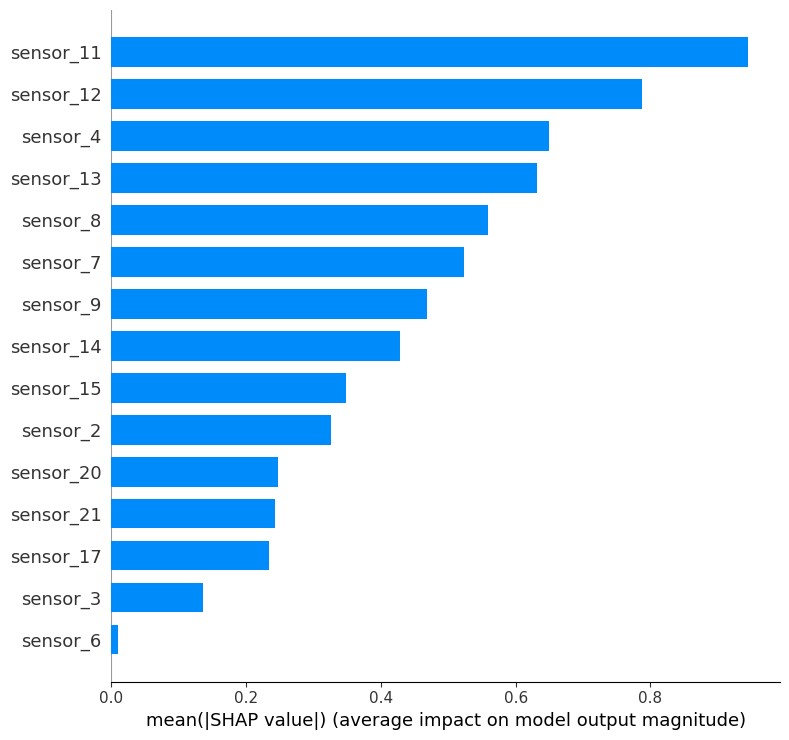

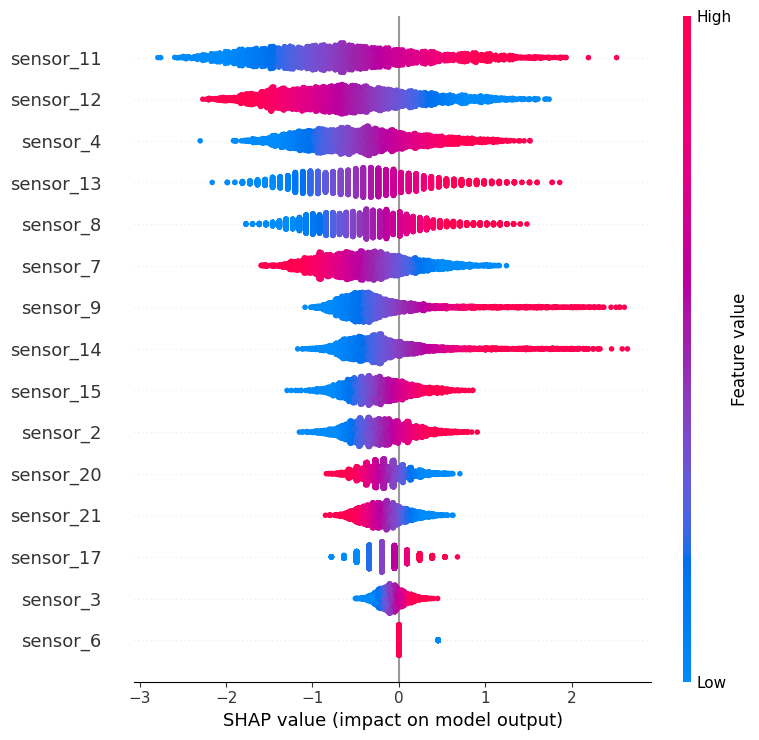

Figuras SHAP guardadas en: figuras/shap_bar.png y figuras/shap_summary.png


In [ ]:
# ====================================#
#   PREPROCESAMIENTO + EVALUACIÓN     #
#        (versión final unificada)    #
# ====================================#


# ---------------------------
# Helper para mostrar tablas
# ---------------------------
def show(df, title):
    print(f"=== {title} ===")
    try:
        display(df.style.set_table_styles(
            [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
        ).set_properties(**{'text-align': 'center'}))
    except Exception:
        print(df)

# =======================================
# 0) CONFIG OPCIONAL: MLflow (si existe)
# =======================================

HAS_MLFLOW = False
try:
    import mlflow, mlflow.sklearn
    HAS_MLFLOW = True
    os.environ["MLFLOW_TRACKING_URI"] = os.getenv("MLFLOW_TRACKING_URI", "mlruns")
    mlflow.set_experiment("mantenimiento_predictivo")
except Exception as e:
    print(f"[AVISO] MLflow no disponible ({e}). Seguimos sin tracking MLOps.")

# =======================================
# 1) DEFINICIÓN DE FEATURES Y TARGET
# =======================================
sensores = [c for c in df.columns if c.startswith('sensor_')]
ajustes  = [c for c in df.columns if c.startswith('ajuste_op_')]  # si los usas, añádelos a features
features = sensores
target   = 'requiere_mantenimiento'
grupos   = df['unidad']

X = df[features].copy()
y = df[target].astype(int).copy()

# =======================================
# 2) ELIMINAR BAJA VARIANZA
# =======================================
umbral_var = 1e-8
sel = VarianceThreshold(threshold=umbral_var)
X_var = sel.fit_transform(X)
cols_keep = [col for col, keep in zip(features, sel.get_support()) if keep]
X = pd.DataFrame(X_var, columns=cols_keep, index=df.index)

tabla_varianza = pd.DataFrame({
    "sensor": features,
    "varianza": df[features].var(ddof=0).values,
    "n_unicos": df[features].nunique(dropna=False).values,
    "conservada": [col in cols_keep for col in features]
})
tabla_varianza["motivo"] = np.where(
    tabla_varianza["conservada"],
    "Conservada (varianza > umbral)",
    np.where(tabla_varianza["n_unicos"] <= 1,
             "Descartada: constante (n_unicos ≤ 1)",
             f"Descartada: varianza ≤ {umbral_var:g}")
)

resumen_varianza = pd.DataFrame({
    "Indicador": ["Sensores iniciales", "Sensores útiles tras varianza"],
    "Valor":     [len(features), len(cols_keep)]
})
show(resumen_varianza, "RESUMEN DE VARIANZA")

# =======================================
# 3) TRAIN/TEST SPLIT por UNIDAD (sin fuga)
# =======================================
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=grupos))

X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
y_train, y_test = y.iloc[train_idx].copy(), y.iloc[test_idx].copy()

tabla_split = pd.DataFrame({
    "Conjunto": ["Train", "Test"],
    "Filas":    [X_train.shape[0], X_test.shape[0]],
    "Columnas": [X_train.shape[1], X_test.shape[1]],
})
show(tabla_split, "DIVISIÓN DE DATOS POR UNIDAD")

# =======================================
# 4) ESCALADO MIN-MAX (fit solo en train)
# =======================================
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# =======================================
# 5) SMOTE (solo entrenamiento)
# =======================================
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

tabla_clases = pd.DataFrame({
    "Clase": ["No (0)", "Sí (1)"],
    "Train antes (#)": [(y_train==0).sum(), (y_train==1).sum()],
    "Train antes (%)": [f"{(y_train==0).mean()*100:.2f}", f"{(y_train==1).mean()*100:.2f}"],
    "Test  antes (#)": [(y_test==0).sum(), (y_test==1).sum()],
    "Test  antes (%)": [f"{(y_test==0).mean()*100:.2f}", f"{(y_test==1).mean()*100:.2f}"],
    "Train SMOTE (#)": [(y_train_bal==0).sum(), (y_train_bal==1).sum()]
})
show(tabla_clases, "DISTRIBUCIÓN DE LA ETIQUETA (antes y después de SMOTE)")

# =======================================
# 6) PCA (95% varianza)
# =======================================
pca = PCA(n_components=0.95, svd_solver='full', random_state=42)
X_train_pca = pca.fit_transform(X_train_bal)
X_test_pca  = pca.transform(X_test_scaled)

tabla_pca = pd.DataFrame({
    "Indicador": ["Componentes PCA retenidos", "Varianza explicada acumulada (%)"],
    "Valor": [X_train_pca.shape[1], f"{pca.explained_variance_ratio_.sum()*100:.2f}"]
})
show(tabla_pca, "RESUMEN PCA")

# ==================================================
# 7) MÉTRICAS BÁSICAS y búsqueda del MEJOR UMBRAL
# ==================================================
def _metricas_basicas(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    acc = (y_pred == y_true).mean()
    roc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    return {
        "Threshold": float(threshold),
        "Accuracy":  float(acc),
        "Precision": float(pr),
        "Recall":    float(rc),
        "F1":        float(f1),
        "ROC_AUC":   float(roc),
        "PR_AUC":    float(pr_auc)
    }

def _buscar_mejor_umbral(y_true, y_prob, grid=np.linspace(0.05, 0.95, 19), min_precision=0.90):
    # Mejor F1
    mejores = []
    for t in grid:
        m = _metricas_basicas(y_true, y_prob, threshold=t)
        mejores.append(m)
    df_m = pd.DataFrame(mejores).sort_values("F1", ascending=False).reset_index(drop=True)
    best_f1 = df_m.iloc[0].to_dict()

    # Umbral con precisión >= min_precision maximizando recall (y F1 como desempate)
    candidatos = df_m[df_m["Precision"] >= min_precision].copy()
    if len(candidatos) > 0:
        best_prec = candidatos.sort_values(["Recall", "F1"], ascending=False).iloc[0].to_dict()
    else:
        best_prec = {"Threshold": None, "Precision": None, "Recall": None, "F1": None}

    return best_f1, best_prec, df_m

# =========================================================
# 8) VALIDACIÓN CRUZADA k=5 (pipeline completo, por unidad)
# =========================================================
CLF_CV = MLPClassifier(hidden_layer_sizes=(64, 32), activation="relu", solver="adam",
                       alpha=1e-3, learning_rate_init=5e-4,
                       early_stopping=True, n_iter_no_change=10,
                       validation_fraction=0.1, max_iter=600, random_state=42)

pipe_cv = Pipeline(steps=[
    ('var', VarianceThreshold(threshold=1e-8)),
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state=42)),                     # solo en train dentro de cada fold
    ('pca', PCA(n_components=0.95, svd_solver='full', random_state=42)),
    ('clf', CLF_CV)
])

try:
    cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
except Exception:
    cv = GroupKFold(n_splits=5)

scoring = ['roc_auc', 'average_precision']  # PR-AUC = average_precision

cv_res = cross_validate(
    estimator=pipe_cv,
    X=df[features],
    y=df[target].astype(int).values,
    groups=df['unidad'].values,
    cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False
)

cv_tabla = pd.DataFrame({
    "Métrica": ["ROC_AUC", "PR_AUC"],
    "Media":  [cv_res['test_roc_auc'].mean(),           cv_res['test_average_precision'].mean()],
    "STD":    [cv_res['test_roc_auc'].std(),            cv_res['test_average_precision'].std()]
}).round(4)
show(cv_tabla, "VALIDACIÓN CRUZADA k=5 (media ± DE) — Pipeline completo por unidad")

# =======================================
# 9) MODELOS a comparar
# =======================================
# XGBoost condicional
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

modelos = []
modelos.append(("Dummy (estratificado)", DummyClassifier(strategy="stratified", random_state=42)))

modelos.append(("LogisticRegression",
                LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)))

modelos.append(("RandomForest",
                RandomForestClassifier(n_estimators=400, max_depth=None, min_samples_split=2,
                                       min_samples_leaf=1, n_jobs=-1,
                                       class_weight="balanced_subsample", random_state=42)))

modelos.append(("MLP",
                MLPClassifier(hidden_layer_sizes=(64, 32),
                              activation="relu", solver="adam",
                              alpha=1e-3, learning_rate_init=5e-4,
                              early_stopping=True, n_iter_no_change=10,
                              validation_fraction=0.1,
                              max_iter=600, random_state=42)))

if HAS_XGB:
    modelos.append(("XGBoost",
                    XGBClassifier(
                        n_estimators=600, max_depth=5, learning_rate=0.05,
                        subsample=0.9, colsample_bytree=0.9,
                        reg_lambda=1.0, reg_alpha=0.0, n_jobs=-1,
                        random_state=42, objective="binary:logistic",
                        eval_metric="logloss", tree_method="hist"
                    )))

# =======================================
# 10) Utilidades de COMPARATIVA (tiempos, complejidad)
# =======================================
import time
try:
    import xgboost as xgb
    _HAS_XGB_ = True
except Exception:
    _HAS_XGB_ = False

def proxy_complejidad(modelo, n_features_pca: int) -> str:
    if isinstance(modelo, LogisticRegression):
        return f"Coef={n_features_pca}"
    if isinstance(modelo, RandomForestClassifier):
        return f"Árboles={modelo.n_estimators}, depth={modelo.max_depth}"
    if _HAS_XGB_ and isinstance(modelo, xgb.XGBClassifier):
        return f"Boosting: {modelo.n_estimators} x depth {modelo.max_depth}"
    if isinstance(modelo, MLPClassifier):
        hs = modelo.hidden_layer_sizes if isinstance(modelo.hidden_layer_sizes, tuple) else (modelo.hidden_layer_sizes,)
        sizes = (X_train_pca.shape[1], *hs, 1)
        params = sum(sizes[i]*sizes[i+1] + sizes[i+1] for i in range(len(sizes)-1))
        return f"Paráms≈{params:,}".replace(",", ".")
    return "N/A"

FUENTES_MODELO = {
    "LogisticRegression": "scikit-learn",
    "RandomForest": "Breiman (2001)",
    "XGBoost": "Chen & Guestrin (2016)",
    "MLP": "Goodfellow et al. (2016)",
    "Dummy (estratificado)": "baseline"
}

# =======================================
# 11) ENTRENAMIENTO, UMBRALES y REPORTES
# =======================================
resultados = []
detalles_umbral = {}

for nombre, modelo in modelos:
    clf = modelo

    # --- tiempo de ENTRENAMIENTO
    t0 = time.perf_counter()
    clf.fit(X_train_pca, y_train_bal)
    t1 = time.perf_counter()
    train_time_s = t1 - t0

    # --- PREDICCIONES (probabilidades) y tiempo
    t2 = time.perf_counter()
    if hasattr(clf, "predict_proba"):
        y_prob_test = clf.predict_proba(X_test_pca)[:, 1]
    elif hasattr(clf, "decision_function"):
        s = clf.decision_function(X_test_pca)
        y_prob_test = (s - s.min()) / (s.max() - s.min() + 1e-12)
    else:
        y_prob_test = clf.predict(X_test_pca).astype(float)
    t3 = time.perf_counter()
    pred_time_ms = (t3 - t2) * 1000.0

    # --- Métricas @0.50
    met_050 = _metricas_basicas(y_test.values, y_prob_test, threshold=0.50)

    # --- Mejor umbral por F1 y alternativa con Prec≥0.90
    best_f1, best_prec90, df_m = _buscar_mejor_umbral(y_test.values, y_prob_test)
    detalles_umbral[nombre] = df_m

    # --- Fila para comparativa
    fila = {
        "Modelo": nombre,
        "ACC@0.50": met_050["Accuracy"],
        "PRC@0.50": met_050["Precision"],
        "REC@0.50": met_050["Recall"],
        "F1@0.50":  met_050["F1"],
        "ROC_AUC":  met_050["ROC_AUC"],
        "PR_AUC":   met_050["PR_AUC"],
        "TH_optF1": float(best_f1["Threshold"]),
        "F1@opt":   float(best_f1["F1"]),
        "REC@opt":  float(best_f1["Recall"]),
        "Train_s":  round(train_time_s, 3),
        "Pred_ms":  round(pred_time_ms, 3),
        "Complejidad": proxy_complejidad(clf, X_train_pca.shape[1]),
        "Fuente":   FUENTES_MODELO.get(nombre, "—"),
    }
    resultados.append(fila)

    # --- MLflow opcional por modelo
    if HAS_MLFLOW:
        try:
            with mlflow.start_run(run_name=nombre):
                mlflow.log_param("modelo", nombre)
                mlflow.log_param("pca_components", X_train_pca.shape[1])
                mlflow.log_param("umbral_opt_f1", float(best_f1["Threshold"]))
                try:
                    mlflow.log_params(getattr(clf, "get_params")())
                except Exception:
                    pass

                for k, v in met_050.items():
                    if k in ["Threshold"]:
                        continue
                    mlflow.log_metric(f"{k.lower()}_050", float(v))

                mlflow.log_metric("f1_opt", float(best_f1["F1"]))
                mlflow.log_metric("rec_opt", float(best_f1["Recall"]))
                mlflow.log_metric("th_opt", float(best_f1["Threshold"]))
                mlflow.log_metric("train_time_s", float(train_time_s))
                mlflow.log_metric("pred_time_ms", float(pred_time_ms))

                # Artefactos por modelo
                y_pred_opt = (y_prob_test >= float(best_f1["Threshold"])).astype(int)
                cm_model = confusion_matrix(y_test.values, y_pred_opt)
                df_cm_model = pd.DataFrame(cm_model, index=["Real 0","Real 1"], columns=["Pred 0","Pred 1"])
                cm_path = f"cm_{nombre.replace(' ','_')}.csv"
                df_cm_model.to_csv(cm_path, index=True)
                mlflow.log_artifact(cm_path)

                umbral_path = f"umbrales_{nombre.replace(' ','_')}.csv"
                df_m.to_csv(umbral_path, index=False)
                mlflow.log_artifact(umbral_path)

                # Log de modelo con firma
                try:
                    from mlflow.models import infer_signature
                    X_example = X_train_pca[:10]
                    if hasattr(clf, "predict_proba"):
                        y_example = clf.predict_proba(X_example)[:, 1]
                    elif hasattr(clf, "decision_function"):
                        s = clf.decision_function(X_example)
                        y_example = (s - s.min()) / (s.max() - s.min() + 1e-12)
                    else:
                        y_example = clf.predict(X_example).astype(float)

                    signature = infer_signature(X_example, y_example)
                    mlflow.sklearn.log_model(
                        sk_model=clf,
                        name=f"{nombre}_model",
                        input_example=X_example,
                        signature=signature
                    )
                except Exception as e:
                    print(f"[AVISO] No se pudo loguear el modelo en MLflow: {e}")
        except Exception as e:
            print(f"[AVISO] Falló el run de MLflow: {e}")

# ------------------------------------------
# 12) TABLA COMPARATIVA FINAL + SELECCIÓN
# ------------------------------------------
df_resultados = pd.DataFrame(resultados)
show(df_resultados.sort_values("F1@opt", ascending=False).reset_index(drop=True),
     "=== COMPARATIVA DE MODELOS (ordenado por F1@opt) ===")

# Selección del mejor por F1@opt
sel = df_resultados.sort_values("F1@opt", ascending=False).iloc[0]
mejor_nombre = sel["Modelo"]
mejor_th = float(sel["TH_optF1"])
print("\n=== MODELO SELECCIONADO ===")
print(pd.DataFrame({"Seleccionado":[mejor_nombre], "Umbral óptimo (F1)":[mejor_th]}))

# Re-entrenar el modelo ganador y evaluar en TEST @TH=mejor_th
modelo_sel = None
for nm, md in modelos:
    if nm == mejor_nombre:
        modelo_sel = md
        break

modelo_sel.fit(X_train_pca, y_train_bal)
if hasattr(modelo_sel, "predict_proba"):
    y_prob_test_sel = modelo_sel.predict_proba(X_test_pca)[:, 1]
elif hasattr(modelo_sel, "decision_function"):
    s = modelo_sel.decision_function(X_test_pca)
    y_prob_test_sel = (s - s.min()) / (s.max() - s.min() + 1e-12)
else:
    y_prob_test_sel = modelo_sel.predict(X_test_pca).astype(float)

y_pred_best = (y_prob_test_sel >= mejor_th).astype(int)

cm = confusion_matrix(y_test.values, y_pred_best)
df_cm = pd.DataFrame(cm, index=["Real 0","Real 1"], columns=["Pred 0","Pred 1"])
show(df_cm, f"MATRIZ DE CONFUSIÓN (TEST) — {mejor_nombre} @TH={mejor_th:.2f}")

print("\n=== REPORTE DE CLASIFICACIÓN (TEST) — "
      f"{mejor_nombre} @TH={mejor_th:.2f} ===")
print(classification_report(y_test.values, y_pred_best, digits=6))

# Vista final solicitada para la tesis
cols_finales = [
    "Modelo", "F1@opt", "REC@opt", "ROC_AUC", "PR_AUC", "TH_optF1",
    "Train_s", "Pred_ms", "Complejidad", "Fuente"
]
df_comp = df_resultados[cols_finales].sort_values("F1@opt", ascending=False).reset_index(drop=True)
show(df_comp, "COMPARATIVA FINAL (F1 principal, tiempos, complejidad y fuente)")

# ------------------------------------------
# 13) GUARDAR ARTEFACTOS (paquete producción)
# ------------------------------------------
artefactos = {
    "scaler": scaler,
    "pca": pca,
    "modelo": modelo_sel,
    "umbral": mejor_th,
    "columnas_esperadas": cols_keep
}
dump(artefactos, "artefactos_mantenimiento.joblib")

# MLflow: run de "producción"
if HAS_MLFLOW:
    try:
        with mlflow.start_run(run_name=f"PRODUCCION_{mejor_nombre}"):
            mlflow.log_param("modelo_seleccionado", mejor_nombre)
            mlflow.log_param("umbral_operativo", mejor_th)
            mlflow.log_artifact("artefactos_mantenimiento.joblib")
    except Exception as e:
        print(f"[AVISO] No se pudo loguear el paquete de producción: {e}")

# ------------------------------------------
# 14) EXPLICABILIDAD: Retroproyección (PCA→vars)
# ------------------------------------------
try:
    modelo_final = artefactos["modelo"]
    pca_final = artefactos["pca"]
    scaler_final = artefactos["scaler"]
    cols_orig = artefactos["columnas_esperadas"]

    if hasattr(modelo_final, "coef_") and pca_final is not None:
        beta_pca = modelo_final.coef_.ravel()          # coeficientes en espacio PCA
        loadings = pca_final.components_               # [n_comp x n_features]
        beta_orig_scaled = loadings.T @ beta_pca       # retroproyección (escala MinMax)

        # Ajuste a escala original: dividir por scale_ (=1/(max-min))
        scale_series = pd.Series(scaler_final.scale_, index=cols_orig).replace(0.0, np.nan)
        beta_orig_unscaled = pd.Series(beta_orig_scaled, index=cols_orig) / scale_series
        beta_orig_unscaled = beta_orig_unscaled.fillna(0.0)

        df_imp_scaled = (
            pd.DataFrame({"variable": cols_orig, "coef_retroproj_scaled": beta_orig_scaled})
              .assign(imp_abs=lambda d: d["coef_retroproj_scaled"].abs())
              .sort_values("imp_abs", ascending=False)
        )
        df_imp_unscaled = (
            beta_orig_unscaled.rename("coef_retroproj_unscaled").reset_index().rename(columns={"index": "variable"})
              .assign(imp_abs=lambda d: d["coef_retroproj_unscaled"].abs())
              .sort_values("imp_abs", ascending=False)
        )

        show(df_imp_scaled.head(20).round(6), "TOP-20 VARIABLES (retroproyección PCA, escala MinMax)")
        show(df_imp_unscaled.head(20).round(6), "TOP-20 VARIABLES (retroproyección PCA, escala ORIGINAL)")
        print("NOTA: El signo indica dirección sobre la probabilidad de clase 1.")
    else:
        print("Retroproyección no disponible: el modelo seleccionado no es lineal (coef_) o no hay PCA.")
except Exception as e:
    print(f"[AVISO] No se pudo realizar la retroproyección: {e}")

# ------------------------------------------
# 15) EXPLICABILIDAD con SHAP (modelo auxiliar sin PCA)
#     - Sin FutureWarning: usa masker y API moderna
#     - Muestra en Colab y guarda PNG en ./figuras
# ------------------------------------------
try:
    import shap
    import matplotlib.pyplot as plt

    # Datos escalados con nombres de columnas
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cols_keep, index=X_train.index)
    X_test_scaled_df  = pd.DataFrame(X_test_scaled,  columns=cols_keep, index=X_test.index)

    # Modelo auxiliar simple para interpretar variables originales
    lr_interp = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
    X_train_bal_df = pd.DataFrame(X_train_bal, columns=cols_keep)
    lr_interp.fit(X_train_bal_df, y_train_bal)

    # Explainer con masker (evita feature_perturbation deprecado)
    masker = shap.maskers.Independent(X_train_bal_df)
    explainer = shap.LinearExplainer(lr_interp, masker=masker)

    # SHAP values sobre TEST (escalado, sin PCA)
    shap_out = explainer(X_test_scaled_df)   # Explanation
    shap_vals = shap_out.values              # [n_samples, n_features]

    # Importancia global TOP-20
    shap_mean = pd.DataFrame({
        "variable": cols_keep,
        "shap_abs_mean": np.abs(shap_vals).mean(axis=0)
    }).sort_values("shap_abs_mean", ascending=False)
    show(shap_mean.head(20).round(6), "TOP-20 VARIABLES POR SHAP ABSOLUTO (modelo auxiliar sin PCA)")

    # Mostrar y guardar figuras
    import os
    os.makedirs("figuras", exist_ok=True)

    # Summary bar
    shap.summary_plot(shap_vals, features=X_test_scaled_df, feature_names=cols_keep, plot_type="bar", show=False)
    plt.tight_layout()
    plt.savefig("figuras/shap_bar.png", dpi=160)
    plt.show()
    plt.close()

    # Summary dot
    shap.summary_plot(shap_vals, features=X_test_scaled_df, feature_names=cols_keep, show=False)
    plt.tight_layout()
    plt.savefig("figuras/shap_summary.png", dpi=160)
    plt.show()
    plt.close()

    print("Figuras SHAP guardadas en: figuras/shap_bar.png y figuras/shap_summary.png")

except ModuleNotFoundError:
    print("[AVISO] SHAP no está instalado. Instala con: !pip install shap")
except Exception as e:
    print(f"[AVISO] SHAP falló: {e}")

# ------------------------------------------
# 16) FUNCIÓN DE INFERENCIA EN LOTE
# ------------------------------------------
def predecir_en_lote(df_nuevo: pd.DataFrame, path_joblib="artefactos_mantenimiento.joblib",
                     prob_col="prob", pred_col="pred"):
    """
    Aplica el mismo pipeline para datos con columnas 'columnas_esperadas'.
    df_nuevo: DataFrame con las columnas esperadas (mismos nombres que 'columnas_esperadas').
    """
    arts = load(path_joblib)
    scaler = arts["scaler"]; pca = arts["pca"]; model = arts["modelo"]; th = arts["umbral"]
    cols = arts["columnas_esperadas"]

    Xn = df_nuevo[cols].copy()
    Xn_sc = scaler.transform(Xn)
    Xn_pca = pca.transform(Xn_sc)
    if hasattr(model, "predict_proba"):
        p = model.predict_proba(Xn_pca)[:, 1]
    elif hasattr(model, "decision_function"):
        s = model.decision_function(Xn_pca)
        p = (s - s.min()) / (s.max() - s.min() + 1e-12)
    else:
        p = model.predict(Xn_pca).astype(float)

    df_out = df_nuevo.copy()
    df_out[prob_col] = p
    df_out[pred_col] = (p >= th).astype(int)
    return df_out


In [ ]:
# ==== Inventario de entorno y versiones (listo para Colab/Jupyter) ====


PKGS = [
    ("numpy", "numpy"),
    ("pandas", "pandas"),
    ("scikit-learn", "sklearn"),
    ("imbalanced-learn", "imblearn"),
    ("xgboost", "xgboost"),
    ("shap", "shap"),
    ("mlflow", "mlflow"),
]

def get_version(modname):
    try:
        mod = importlib.import_module(modname)
        ver = getattr(mod, "__version__", "n/a")
        return ver
    except Exception as e:
        return f"no instalado ({e.__class__.__name__})"

# Info de BLAS/Math backend (NumPy)
def numpy_blas_info():
    try:
        import numpy.__config__ as ncfg
        # Busca info relevante (openblas, mkl, blas_opt)
        keys = ["openblas_info", "openblas_ilp64_info", "blas_mkl_info", "mkl_info", "blas_opt_info"]
        info = {}
        for k in keys:
            d = ncfg.get_info(k)
            if d:
                info[k] = {kk: (vv if isinstance(vv, (str,int,float)) else str(vv)) for kk, vv in d.items()}
        return info or {"detalle": "no se detectó backend específico"}
    except Exception as e:
        return {"detalle": f"no disponible ({e.__class__.__name__})"}

# Info de GPU (Colab) si existe
def gpu_info():
    try:
        # Si no hay nvidia-smi, esto fallará
        import subprocess
        out = subprocess.run(["nvidia-smi", "--query-gpu=name,driver_version,memory.total", "--format=csv,noheader"],
                             capture_output=True, text=True)
        if out.returncode == 0:
            return {"nvidia-smi": out.stdout.strip()}
        else:
            return {"nvidia-smi": "Sin GPU (runtime CPU)"}
    except Exception:
        return {"nvidia-smi": "Sin GPU (runtime CPU)"}

env = {
    "timestamp": datetime.datetime.now().isoformat(timespec="seconds"),
    "python_version": platform.python_version(),
    "implementation": platform.python_implementation(),
    "platform": platform.platform(),
    "system": platform.system(),
    "release": platform.release(),
    "machine": platform.machine(),
    "processor": platform.processor() or "n/a",
    "cpu_count": os.cpu_count(),
}

# Recoge versiones de paquetes
versions = {name: get_version(mod) for (name, mod) in PKGS}

# Imprime resumen amigable
print("=== ENTORNO ===")
for k, v in env.items():
    print(f"{k}: {v}")

print("\n=== LIBRERÍAS ===")
for disp, mod in PKGS:
    print(f"{disp}: {versions[disp]}")

# Detalle NumPy/BLAS
print("\n=== NumPy/BLAS backend ===")
print(json.dumps(numpy_blas_info(), indent=2))

# GPU (si aplica)
print("\n=== GPU ===")
print(json.dumps(gpu_info(), indent=2))

# Extra: versión detallada de scikit-learn (si está instalado)
try:
    import sklearn
    from sklearn import show_versions
    print("\n=== sklearn.show_versions() (resumen extendido) ===")
    show_versions()
except Exception:
    pass

# (Opcional) Guardar a CSV/JSON para anexos
try:
    import pandas as pd
    rows = [{"package": disp, "module": mod, "version": versions[disp]} for (disp, mod) in PKGS]
    dfv = pd.DataFrame(rows)
    out_dir = Path("entorno_info"); out_dir.mkdir(exist_ok=True)
    dfv.to_csv(out_dir / "versions_libs.csv", index=False)
    with open(out_dir / "env_system.json", "w") as f:
        json.dump({"env": env, "numpy_blas": numpy_blas_info(), "gpu": gpu_info()}, f, indent=2)
    print(f"\nArchivos guardados en: {out_dir}/versions_libs.csv y {out_dir}/env_system.json")
except Exception as e:
    print(f"[AVISO] No se pudo exportar CSV/JSON: {e}")


=== ENTORNO ===
timestamp: 2025-10-08T04:14:21
python_version: 3.12.11
implementation: CPython
platform: Linux-6.6.97+-x86_64-with-glibc2.35
system: Linux
release: 6.6.97+
machine: x86_64
processor: x86_64
cpu_count: 2

=== LIBRERÍAS ===
numpy: 2.0.2
pandas: 2.2.2
scikit-learn: 1.6.1
imbalanced-learn: 0.14.0
xgboost: 3.0.5
shap: 0.48.0
mlflow: 3.4.0

=== NumPy/BLAS backend ===
{
  "detalle": "no disponible (AttributeError)"
}

=== GPU ===
{
  "nvidia-smi": "Sin GPU (runtime CPU)"
}

=== sklearn.show_versions() (resumen extendido) ===

System:
    python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
executable: /usr/bin/python3
   machine: Linux-6.6.97+-x86_64-with-glibc2.35

Python dependencies:
      sklearn: 1.6.1
          pip: 24.1.2
   setuptools: 75.2.0
        numpy: 2.0.2
        scipy: 1.16.2
       Cython: 3.0.12
       pandas: 2.2.2
   matplotlib: 3.10.0
       joblib: 1.5.2
threadpoolctl: 3.6.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   int